# Prediction Mechanism 

## Import all relevant libraries and data

In [1]:
!pip install pandas
!pip install seaborn
!pip install keras
!pip install sklearn

In [2]:
!pip install pydot
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras.optimizers import Adam
from keras.utils import plot_model
from tensorflow import keras
from keras.models import Sequential, save_model, load_model
from keras.layers import LSTM, Dense, Dropout, GRU
from sklearn.preprocessing import MinMaxScaler


## Data Visualization

#### A file is chosen as a sample. The code is generalized for all such files.

In [3]:
abl = pd.read_csv('Companies/ABL PA Equity.csv') 
abl.tail()

,Date,Open,High,Low,Close,Volume
3947,2020-10-02,87.01,87.50,86.00,86.00,8000.0
3948,2020-10-05,86.99,92.44,81.04,83.83,63500.0
3949,2020-10-06,83.11,85.47,83.00,83.00,50000.0
3950,2020-10-07,82.60,84.35,82.50,82.94,37500.0
3951,2020-10-08,82.91,89.16,82.36,86.73,79000.0


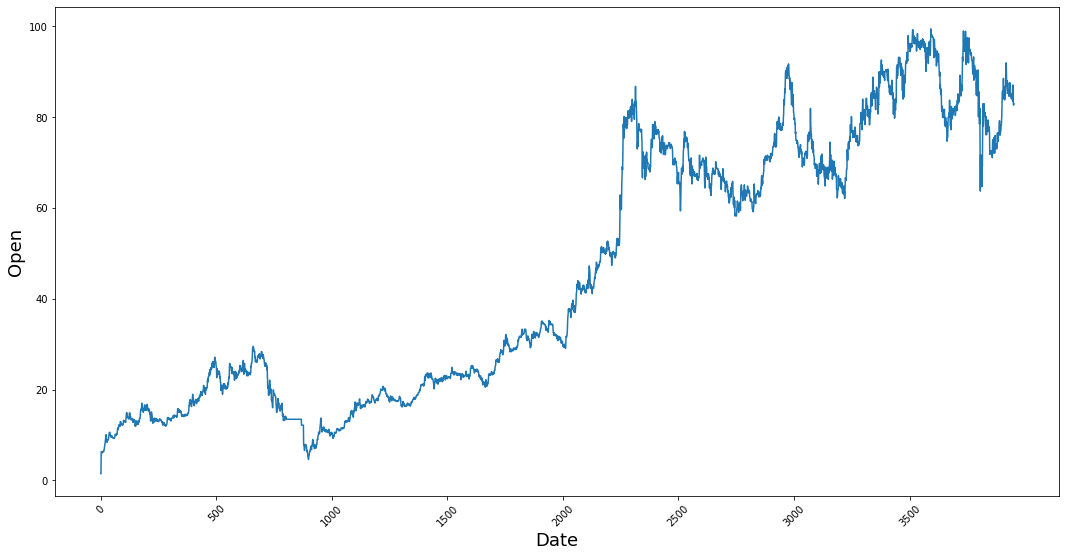

In [4]:
plt.figure(figsize = (18,9))
plt.plot(range(abl.shape[0]), abl['Open'])
plt.xticks(range(0, abl.shape[0], 500), rotation=45)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Open', fontsize=18)
plt.show()

# Test-Train-Validation Split

#### The data is split into 3 parts. 

#### The first is the train part where we provide the model real prices as input and labels. It analyses the prices and attempts to predict the next day price. When predicted, the actual price for that day is given so it can learn accordingly.

#### The second is the test part, where we provide the model data it has not seen before and ask it to predict using this new data entirely.

#### The third part is the validation part. We keep some data never shown to the model in train and test parts and then ask it to predict this without ever seeing it.

In [5]:
def test_train_split(df, column):

    prices = df[column] #We choose to predict the price of the given column

    # 80-20 split into Train-Test

    train_data = prices[:int(len(prices)*0.7)]
    test_data = prices[int(len(prices)*0.7):int(len(prices)*0.8)]
    val_data = prices[int(len(prices)*0.8):]
    
    #Convert to ndarray

    train_data = np.asarray(train_data)
    test_data = np.asarray(test_data)
    val_data = np.asarray(val_data)
    
    #Transform data
    
    train_data = train_data.reshape(-1, 1)
    test_data = test_data.reshape(-1, 1)
    val_data = val_data.reshape(-1, 1)
    

    print(train_data.shape[0])
    print(test_data.shape[0])
    print(val_data.shape[0])

    
    return train_data, test_data, val_data
    
train_data, test_data, val_data = test_train_split(abl, 'Open')

2766
395
791


## Check distribution of data with scaling

#### A recurrent neural network works better when data is squished between a limit. We want to see if scaling our data this way has any change on its distribution. 

{'whiskers': [<matplotlib.lines.Line2D at 0x28b3bda2430>,
 'caps': [<matplotlib.lines.Line2D at 0x28b3bda2a00>,
 'boxes': [<matplotlib.patches.PathPatch at 0x28b3bda2070>],
 'medians': [<matplotlib.lines.Line2D at 0x28b3bdb3190>],
 'fliers': [<matplotlib.lines.Line2D at 0x28b3bdb3520>],
 'means': []}

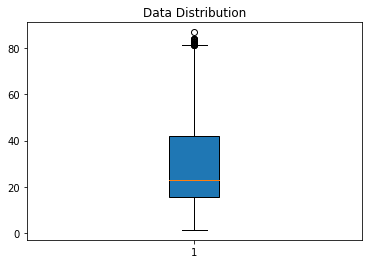

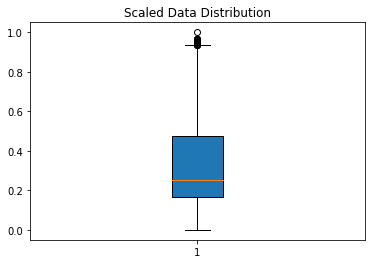

In [6]:
fig1, ax1 = plt.subplots()
ax1.set_title('Data Distribution')
ax1.boxplot(train_data, patch_artist=True)

tempScaler = MinMaxScaler()
scaled_data = tempScaler.fit_transform(train_data)

fig1, ax1 = plt.subplots()
ax1.set_title('Scaled Data Distribution')
ax1.boxplot(scaled_data, patch_artist=True)

#### We can see scaling our data does not change the distribution

## Prepare Train set

#### The data is prepared with the following methodology:

#### We take a window (set of days) to analyze the recent stock movemement. Based on that analysis, and the weight of historical learning (previous analyses), a prediction for  the window+1 day is made. The model compares the predicted price with the original price and adjusts its parameters. This is done iteratively, with a step of window+1 in each iteration. 

#### For example, for a window of 5, the model would look at day 1 to day 5 and predict day 6. Once day 6 is predicted, it would adjust parameters and then move onto the next window of day 7 to day 11 and predict day 12 and so on.

#### The days in the window are stored in x_train (the features). The days to be predicted are stored in y_train (labels). This results in two arrays, x_train and y_train which we would feed into the model

In [7]:
def train_prep(train_data, window, itr):
    scaler = MinMaxScaler((0, 1))
    scaled_train_data = scaler.fit_transform(train_data)

    x_train = [] #Features
    y_train = [] #Labels

    for i in range(window+itr, scaled_train_data.shape[0], window+1): #Make windows of 60 days for training until last day

        x_train.append(scaled_train_data[i-window:i]) #n day window to look back
        y_train.append(scaled_train_data[i:i+1, 0]) #predict for specified days

    x_train = np.array(x_train) 
    y_train = np.array(y_train)
    
        #print(x_train.shape, y_train.shape, scaler.scale_)
    
    return x_train, y_train, scaler.scale_
x_train, y_train, scale_train = train_prep(train_data, 5, 0)

## Prepare test and validation set

#### Exactly the same way as train set, we will make the test set. The only difference is that the test set takes the last window from the train set so it can predict in continuation. 

In [8]:
def test_prep(test_data, train_data, window, itr):
    scaler = MinMaxScaler((0, 1))
    test_data = np.concatenate((train_data[:window], test_data), axis = 0) #Add last previous observations of train data to test
    scaled_test_data = scaler.fit_transform(test_data)

    x_test = []
    y_test = []

    for i in range(window+itr, test_data.shape[0], window+1):
        x_test.append(scaled_test_data[i-window:i])
        y_test.append(scaled_test_data[i:i+1, 0])

    x_test = np.array(x_test)
    y_test = np.array(y_test)
        
        #print(x_test.shape, y_test.shape, scaler.scale_)
    return x_test, y_test, scaler.scale_
    
x_test, y_test, test_scale = test_prep(test_data, train_data, 5, 0)

In [9]:
def val_prep(val_data, test_data, window, itr):
    scaler = MinMaxScaler((0, 1))
    val_data = np.concatenate((test_data[:window], val_data), axis = 0) #Add last previous observations of train data to test
    scaled_val_data = scaler.fit_transform(val_data)

    x_val = []
    y_val = []

    for i in range(window+itr, val_data.shape[0], window+1):
        x_val.append(scaled_val_data[i-window:i])
        y_val.append(scaled_val_data[i:i+1, 0])

    x_val = np.array(x_val)
    y_val = np.array(y_val)
        
    return x_val, y_val, scaler.scale_
    
x_val, y_val, val_scale = val_prep(val_data, test_data, 5, 0)

## Building the GRU

#### We chose the GRU model as it performed the best on our problem. The architecture is such that there are two layers of GRU. The first layer takes the input as we defined in train and test sets. It then forwards its results to the second layer which works similarly. Both layers are activated by ReLU on the output to ensure non-linearity of our problem. 

In [10]:
def create_model(x_train, units_1, units_2):

    model = Sequential()

    model.add(GRU(units = units_1, activation = 'relu', return_sequences = True, input_shape = (x_train.shape[1], x_train.shape[2])))

    model.add(GRU(units = units_2, activation = 'relu'))

    model.add(Dense(units = 1))
    
    return model
    
model = create_model(x_train, 16, 32)

model.summary()

plot_model(model)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 5, 16)             912       
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                4800      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 5,745
Trainable params: 5,745
Non-trainable params: 0
_________________________________________________________________
('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


#### ADAM is an optimizer used to optimize the Stochastic Gradient Descent used to minimize the error the model makes. Mean Squared Error is the error or loss function used to tell the model how to minimize the error in each step. The number of epochs is defined as how many times the model would need to go through the whole data in order to reach the minimum point of the loss. We have chosen the number at which we are sure the loss becomes constant and does not drop significiantly anymore. The batch size is defined as how many training examples should it put in one batch since the parameters are adjusted after each batch.

In [11]:
def compile_model(model, x_train, y_train, x_test, y_test):

    model.compile(optimizer='adam', loss= 'mean_squared_error')
    history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data = (x_test, y_test), verbose = 1)
    return history
history = compile_model(model, x_train, y_train, x_test, y_test)

Epoch 1/10
15/15 [==============================] - 0s 24ms/step - loss: 0.1226 - val_loss: 0.3089
Epoch 2/10
15/15 [==============================] - 0s 4ms/step - loss: 0.0541 - val_loss: 0.1052
Epoch 3/10
15/15 [==============================] - 0s 3ms/step - loss: 0.0272 - val_loss: 0.0359
Epoch 4/10
15/15 [==============================] - 0s 4ms/step - loss: 0.0200 - val_loss: 0.0515
Epoch 5/10
15/15 [==============================] - 0s 3ms/step - loss: 0.0105 - val_loss: 0.0154
Epoch 6/10
15/15 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 0.0066
Epoch 7/10
15/15 [==============================] - 0s 4ms/step - loss: 4.2739e-04 - val_loss: 0.0061
Epoch 8/10
15/15 [==============================] - 0s 4ms/step - loss: 1.8468e-04 - val_loss: 0.0061
Epoch 9/10
15/15 [==============================] - 0s 4ms/step - loss: 1.6237e-04 - val_loss: 0.0060
Epoch 10/10
15/15 [==============================] - 0s 4ms/step - loss: 1.4640e-04 - val_loss: 0.0059


## Testing

#### This is the part where we test our results. y_hat is an array which holds the predictions done on the test dataset we created earlier. After we have y_hat, we revert the scale of data to get original prices once again. These prices are then plotted to closely see how our model is behaving.

In [12]:
y_hat = model.predict(x_test) #Prediction over test set

In [13]:
y_hat_unscaled = y_hat/test_scale[0]
y_test_unscaled = y_test/test_scale[0]

#Scaling back to original values

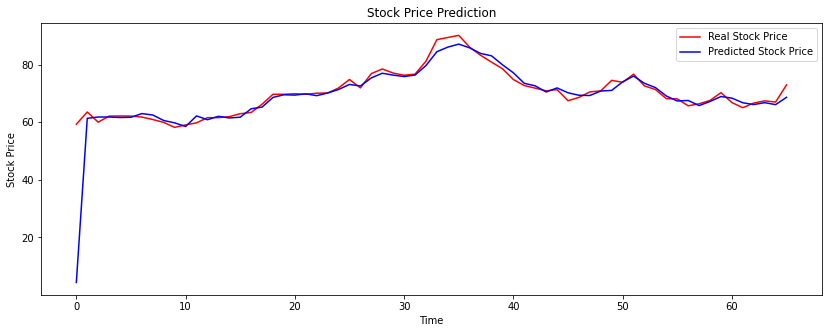

In [14]:
def plot_comparison(y_test, y_hat):

    plt.figure(figsize=(14,5))
    plt.plot(y_test[:], color = 'red', label = 'Real Stock Price')
    plt.plot(y_hat[:], color = 'blue', label = 'Predicted Stock Price')
    plt.title('Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()
    
plot_comparison(y_test_unscaled, y_hat_unscaled)

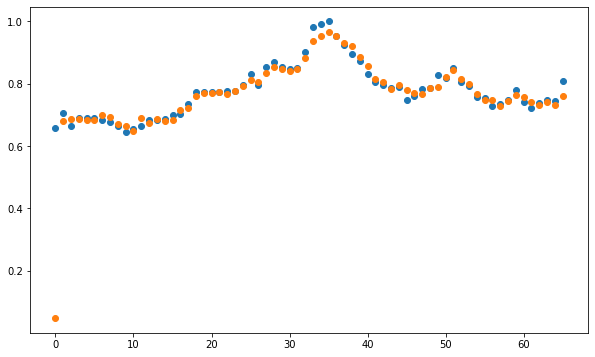

In [15]:
# Define plot space
fig, ax = plt.subplots(figsize=(10, 6))

# Create scatter plot
ax.scatter(range(y_test.shape[0]), 
           y_test)

ax.scatter(range(y_test.shape[0]), 
           y_hat)

plt.show()

## Validating


In [16]:
y_hat_val = model.predict(x_val) #Prediction over val set
y_hat_val_unscaled = y_hat_val/val_scale[0]
y_val_unscaled = y_val/val_scale[0]

#Scaling back to original values

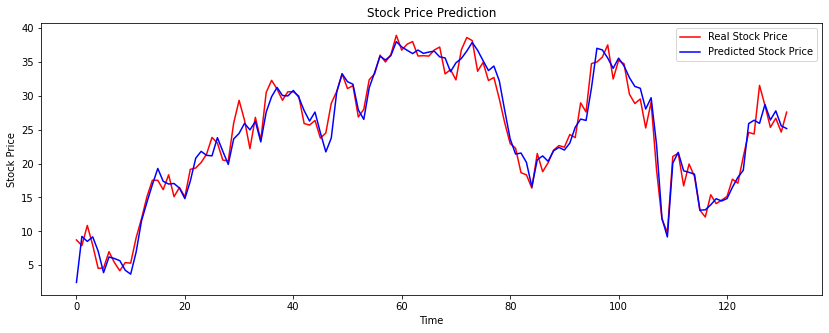

In [17]:
plot_comparison(y_val_unscaled, y_hat_val_unscaled)

In [20]:
mean_acc, lst, summ = [], [], 0,
for i in range(1, len(y_val_unscaled-1)):
    if (y_val_unscaled[i][0] >= y_hat_val_unscaled[i][0]):
        accuracy = (y_hat_val_unscaled[i][0]/y_val_unscaled[i][0])*100
        lst.append(accuracy)
    else:
        accuracy = (y_val_unscaled[i][0]/y_hat_val_unscaled[i][0])*100
        lst.append(accuracy)
for i in lst:
    summ+=i
mean_acc.append(summ/len(lst))
print('Accuracy: ', mean_acc[0],' %')

Accuracy:  93.79880217034483  %


# Pipeline of Module 1

### Running the model on KSE100

In [21]:
KSE100 = pd.read_csv('KSE100.csv')
filtered = KSE100['Ticker'].tolist()
name = []
for i in range(len(filtered)):
    name.append(str(filtered[i]) + ".csv")

In [22]:
a=name[1]
name[1]=name[0]
name[0]=a
print(name)

['UBL PA Equity.csv', 'HBL PA Equity.csv', 'HUBC PA Equity.csv', 'MCB PA Equity.csv', 'OGDC PA Equity.csv', 'LUCK PA Equity.csv', 'ENGRO PA Equity.csv', 'PPL PA Equity.csv', 'FFC PA Equity.csv', 'PSO PA Equity.csv', 'DAWH PA Equity.csv', 'DGKC PA Equity.csv', 'POL PA Equity.csv', 'EFERT PA Equity.csv', 'KAPCO PA Equity.csv', 'NBP PA Equity.csv', 'NESTLE PA Equity.csv', 'SEARL PA Equity.csv', 'BAHL PA Equity.csv', 'FCCL PA Equity.csv', 'MLCF PA Equity.csv', 'KEL PA Equity.csv', 'PSEL PA Equity.csv', 'PIBTL PA Equity.csv', 'PKGS PA Equity.csv', 'NML PA Equity.csv', 'BAFL PA Equity.csv', 'MARI PA Equity.csv', 'PAEL PA Equity.csv', 'FFBL PA Equity.csv', 'KTML PA Equity.csv', 'ABOT PA Equity.csv', 'ABL PA Equity.csv', 'TRG PA Equity.csv', 'EFUG PA Equity.csv', 'FCEPL PA Equity.csv', 'INDU PA Equity.csv', 'NRL PA Equity.csv', 'MUREB PA Equity.csv', 'FATIMA PA Equity.csv', 'HCAR PA Equity.csv', 'NATF PA Equity.csv', 'HASCOL PA Equity.csv', 'PIOC PA Equity.csv', 'HMB PA Equity.csv', 'PAKT PA E

In [23]:
global mean_acc
mean_acc = []
def main(df, column, itre, dates):  
    dfs = pd.DataFrame(columns = ['Date', 'Predicted Price'])
    dates1 = dates[int(len(dates)*0.7):]
    dfs['Date'] = dates1
    for itr in range (0,itre):
        train_data, test_data, val_data = test_train_split(df, column)
        tempScaler = MinMaxScaler()
        scaled_data = tempScaler.fit_transform(train_data)
        x_train, y_train, scale_train = train_prep(train_data, 5, itr)
        x_test, y_test, test_scale = test_prep(test_data, train_data, 5, itr)
        x_val, y_val, val_scale = val_prep(val_data, test_data, 5, itr)
        model = create_model(x_train, 16, 32)
        history = compile_model(model, x_train, y_train, x_test, y_test)
        y_hat = model.predict(x_test)
        y_hat_unscaled = y_hat/test_scale[0]
        y_test_unscaled = y_test/test_scale[0]
        y_hat_val = model.predict(x_val)
        y_hat_val_unscaled = y_hat_val/val_scale[0]
        y_val_unscaled = y_val/val_scale[0] 
        
        j = int(len(dates)*0.7)+itr
        for i in range(len(y_hat)):
            dfs['Predicted Price'][j] = y_hat[i][0]
            j+=6
        j = int(len(dates)*0.8)+itr
        for i in range(len(y_hat_val)):
            dfs['Predicted Price'][j] = y_hat_val[i][0]
            j+=6
    dfs = dfs.iloc[40:]
    #print('complete')
    return dfs

def companies(names):
    for i in names:
        df = pd.read_csv('Companies/'+i) 
        dates = df['Date']
        dfs = main(df, 'Close', 6, dates)
        dfs.to_csv(path_or_buf = 'Module 1/'+i, encoding='utf-8',  sep = ',', index = False) #Save dataframe as CSV
companies(name)

2778
397
794
Epoch 1/10
15/15 [==============================] - 0s 22ms/step - loss: 0.1435 - val_loss: 0.2616
Epoch 2/10
15/15 [==============================] - 0s 4ms/step - loss: 0.0611 - val_loss: 0.0889
Epoch 3/10
15/15 [==============================] - 0s 4ms/step - loss: 0.0251 - val_loss: 0.0201
Epoch 4/10
15/15 [==============================] - 0s 3ms/step - loss: 0.0131 - val_loss: 0.0131
Epoch 5/10
15/15 [==============================] - 0s 4ms/step - loss: 0.0035 - val_loss: 0.0041
Epoch 6/10
15/15 [==============================] - 0s 4ms/step - loss: 2.9314e-04 - val_loss: 0.0040
Epoch 7/10
15/15 [==============================] - 0s 4ms/step - loss: 2.6465e-04 - val_loss: 0.0039
Epoch 8/10
15/15 [==============================] - 0s 3ms/step - loss: 1.6196e-04 - val_loss: 0.0037
Epoch 9/10
15/15 [==============================] - 0s 3ms/step - loss: 1.5537e-04 - val_loss: 0.0037
Epoch 10/10
15/15 [==============================] - 0s 4ms/step - loss: 1.4907e-04 - va

13/13 [==============================] - 0s 24ms/step - loss: 0.1806 - val_loss: 0.2861
Epoch 2/10
13/13 [==============================] - 0s 4ms/step - loss: 0.1041 - val_loss: 0.1450
Epoch 3/10
13/13 [==============================] - 0s 4ms/step - loss: 0.0446 - val_loss: 0.0415
Epoch 4/10
13/13 [==============================] - 0s 4ms/step - loss: 0.0219 - val_loss: 0.0108
Epoch 5/10
13/13 [==============================] - 0s 3ms/step - loss: 0.0159 - val_loss: 0.0129
Epoch 6/10
13/13 [==============================] - 0s 3ms/step - loss: 0.0095 - val_loss: 0.0068
Epoch 7/10
13/13 [==============================] - 0s 4ms/step - loss: 0.0043 - val_loss: 0.0034
Epoch 8/10
13/13 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0028
Epoch 9/10
13/13 [==============================] - 0s 4ms/step - loss: 3.9269e-04 - val_loss: 0.0031
Epoch 10/10
13/13 [==============================] - 0s 3ms/step - loss: 2.8470e-04 - val_loss: 0.0030
2417
346
691
Epoch 1/

19/19 [==============================] - 0s 18ms/step - loss: 0.1030 - val_loss: 0.3121
Epoch 2/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0478 - val_loss: 0.1271
Epoch 3/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0264 - val_loss: 0.0605
Epoch 4/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0118 - val_loss: 0.0176
Epoch 5/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 3.7211e-04
Epoch 6/10
19/19 [==============================] - 0s 3ms/step - loss: 2.7832e-04 - val_loss: 7.1483e-04
Epoch 7/10
19/19 [==============================] - 0s 3ms/step - loss: 1.2959e-04 - val_loss: 4.2933e-04
Epoch 8/10
19/19 [==============================] - 0s 3ms/step - loss: 1.1523e-04 - val_loss: 4.2204e-04
Epoch 9/10
19/19 [==============================] - 0s 4ms/step - loss: 9.9745e-05 - val_loss: 4.5166e-04
Epoch 10/10
19/19 [==============================] - 0s 3ms/step - loss: 8.2443e-05 - val_lo

19/19 [==============================] - 0s 3ms/step - loss: 1.9858e-04 - val_loss: 4.6221e-04
3054
437
873
Epoch 1/10
16/16 [==============================] - 0s 20ms/step - loss: 0.1596 - val_loss: 0.2750
Epoch 2/10
16/16 [==============================] - 0s 4ms/step - loss: 0.0784 - val_loss: 0.1107
Epoch 3/10
16/16 [==============================] - 0s 3ms/step - loss: 0.0368 - val_loss: 0.0281
Epoch 4/10
16/16 [==============================] - 0s 3ms/step - loss: 0.0247 - val_loss: 0.0264
Epoch 5/10
16/16 [==============================] - 0s 3ms/step - loss: 0.0109 - val_loss: 0.0088
Epoch 6/10
16/16 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 0.0053
Epoch 7/10
16/16 [==============================] - 0s 3ms/step - loss: 3.5117e-04 - val_loss: 0.0046
Epoch 8/10
16/16 [==============================] - 0s 3ms/step - loss: 1.8614e-04 - val_loss: 0.0046
Epoch 9/10
16/16 [==============================] - 0s 3ms/step - loss: 1.6599e-04 - val_loss: 0.00

19/19 [==============================] - 0s 3ms/step - loss: 5.4040e-05 - val_loss: 0.0030
3610
516
1032
Epoch 1/10
19/19 [==============================] - 0s 18ms/step - loss: 0.0603 - val_loss: 0.3537
Epoch 2/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0371 - val_loss: 0.2110
Epoch 3/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0248 - val_loss: 0.1302
Epoch 4/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0153 - val_loss: 0.0595
Epoch 5/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0035 - val_loss: 0.0022
Epoch 6/10
19/19 [==============================] - 0s 3ms/step - loss: 3.3903e-04 - val_loss: 0.0045
Epoch 7/10
19/19 [==============================] - 0s 3ms/step - loss: 1.5736e-04 - val_loss: 0.0022
Epoch 8/10
19/19 [==============================] - 0s 3ms/step - loss: 1.2599e-04 - val_loss: 0.0026
Epoch 9/10
19/19 [==============================] - 0s 3ms/step - loss: 1.1081e-04 - val_loss: 0.0

19/19 [==============================] - 0s 3ms/step - loss: 2.4755e-04 - val_loss: 7.0296e-04
Epoch 10/10
19/19 [==============================] - 0s 3ms/step - loss: 2.4185e-04 - val_loss: 6.9685e-04
3610
516
1032
Epoch 1/10
19/19 [==============================] - 0s 18ms/step - loss: 0.1410 - val_loss: 0.4755
Epoch 2/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0760 - val_loss: 0.2743
Epoch 3/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0361 - val_loss: 0.1216
Epoch 4/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0158 - val_loss: 0.0478
Epoch 5/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0039 - val_loss: 0.0088
Epoch 6/10
19/19 [==============================] - 0s 3ms/step - loss: 6.5211e-04 - val_loss: 0.0020
Epoch 7/10
19/19 [==============================] - 0s 3ms/step - loss: 3.4752e-04 - val_loss: 0.0015
Epoch 8/10
19/19 [==============================] - 0s 3ms/step - loss: 2.6144e-04 - val_

Epoch 9/10
16/16 [==============================] - 0s 3ms/step - loss: 1.3652e-04 - val_loss: 3.8898e-04
Epoch 10/10
16/16 [==============================] - 0s 3ms/step - loss: 1.3584e-04 - val_loss: 4.0690e-04
3610
516
1032
Epoch 1/10
19/19 [==============================] - 0s 19ms/step - loss: 0.1621 - val_loss: 0.3983
Epoch 2/10
19/19 [==============================] - 0s 4ms/step - loss: 0.0728 - val_loss: 0.1787
Epoch 3/10
19/19 [==============================] - 0s 4ms/step - loss: 0.0301 - val_loss: 0.0369
Epoch 4/10
19/19 [==============================] - 0s 4ms/step - loss: 0.0066 - val_loss: 0.0053
Epoch 5/10
19/19 [==============================] - 0s 4ms/step - loss: 3.6474e-04 - val_loss: 0.0068
Epoch 6/10
19/19 [==============================] - 0s 4ms/step - loss: 2.4786e-04 - val_loss: 0.0053
Epoch 7/10
19/19 [==============================] - 0s 4ms/step - loss: 1.4594e-04 - val_loss: 0.0053
Epoch 8/10
19/19 [==============================] - 0s 4ms/step - loss: 1.

19/19 [==============================] - 0s 3ms/step - loss: 1.3201e-04 - val_loss: 0.0047
Epoch 9/10
19/19 [==============================] - 0s 3ms/step - loss: 1.2981e-04 - val_loss: 0.0047
Epoch 10/10
19/19 [==============================] - 0s 3ms/step - loss: 1.2345e-04 - val_loss: 0.0046
3610
516
1032
Epoch 1/10
19/19 [==============================] - 0s 18ms/step - loss: 0.0719 - val_loss: 0.2604
Epoch 2/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0193 - val_loss: 0.0693
Epoch 3/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0086 - val_loss: 0.0290
Epoch 4/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0028 - val_loss: 0.0062
Epoch 5/10
19/19 [==============================] - 0s 3ms/step - loss: 4.0298e-04 - val_loss: 0.0024
Epoch 6/10
19/19 [==============================] - 0s 3ms/step - loss: 1.9521e-04 - val_loss: 0.0023
Epoch 7/10
19/19 [==============================] - 0s 3ms/step - loss: 1.5623e-04 - val_loss

Epoch 8/10
19/19 [==============================] - 0s 3ms/step - loss: 3.3325e-04 - val_loss: 6.9299e-04
Epoch 9/10
19/19 [==============================] - 0s 3ms/step - loss: 3.2361e-04 - val_loss: 6.0798e-04
Epoch 10/10
19/19 [==============================] - 0s 3ms/step - loss: 3.0531e-04 - val_loss: 5.6285e-04
3610
516
1032
Epoch 1/10
19/19 [==============================] - 0s 17ms/step - loss: 0.1433 - val_loss: 0.3322
Epoch 2/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0823 - val_loss: 0.1790
Epoch 3/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0301 - val_loss: 0.0351
Epoch 4/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0082 - val_loss: 0.0090
Epoch 5/10
19/19 [==============================] - 0s 3ms/step - loss: 7.7496e-04 - val_loss: 8.2856e-04
Epoch 6/10
19/19 [==============================] - 0s 3ms/step - loss: 3.7847e-04 - val_loss: 7.6918e-04
Epoch 7/10
19/19 [==============================] - 0s 3ms/ste

19/19 [==============================] - 0s 4ms/step - loss: 3.6913e-04 - val_loss: 3.5498e-04
Epoch 8/10
19/19 [==============================] - 0s 4ms/step - loss: 3.2350e-04 - val_loss: 2.6628e-04
Epoch 9/10
19/19 [==============================] - 0s 4ms/step - loss: 3.0731e-04 - val_loss: 2.8981e-04
Epoch 10/10
19/19 [==============================] - 0s 3ms/step - loss: 2.8335e-04 - val_loss: 2.6318e-04
3610
516
1032
Epoch 1/10
19/19 [==============================] - 0s 17ms/step - loss: 0.0982 - val_loss: 0.1975
Epoch 2/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0291 - val_loss: 0.0320
Epoch 3/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0058 - val_loss: 0.0103
Epoch 4/10
19/19 [==============================] - 0s 3ms/step - loss: 3.6793e-04 - val_loss: 0.0110
Epoch 5/10
19/19 [==============================] - 0s 3ms/step - loss: 1.3869e-04 - val_loss: 0.0099
Epoch 6/10
19/19 [==============================] - 0s 3ms/step - loss: 9

7/7 [==============================] - 0s 4ms/step - loss: 0.0105 - val_loss: 0.0164
Epoch 8/10
7/7 [==============================] - 0s 4ms/step - loss: 0.0126 - val_loss: 0.0139
Epoch 9/10
7/7 [==============================] - 0s 4ms/step - loss: 0.0094 - val_loss: 0.0353
Epoch 10/10
7/7 [==============================] - 0s 4ms/step - loss: 0.0086 - val_loss: 0.0308
1227
176
351
Epoch 1/10
7/7 [==============================] - 0s 44ms/step - loss: 0.3666 - val_loss: 0.7326
Epoch 2/10
7/7 [==============================] - 0s 6ms/step - loss: 0.2834 - val_loss: 0.5834
Epoch 3/10
7/7 [==============================] - 0s 5ms/step - loss: 0.2071 - val_loss: 0.4296
Epoch 4/10
7/7 [==============================] - 0s 5ms/step - loss: 0.1332 - val_loss: 0.2794
Epoch 5/10
7/7 [==============================] - 0s 4ms/step - loss: 0.0675 - val_loss: 0.1382
Epoch 6/10
7/7 [==============================] - 0s 5ms/step - loss: 0.0220 - val_loss: 0.0377
Epoch 7/10
7/7 [====================

2827
404
808
Epoch 1/10
15/15 [==============================] - 1s 57ms/step - loss: 0.1160 - val_loss: 0.5531
Epoch 2/10
15/15 [==============================] - 0s 4ms/step - loss: 0.0693 - val_loss: 0.3259
Epoch 3/10
15/15 [==============================] - 0s 3ms/step - loss: 0.0361 - val_loss: 0.1398
Epoch 4/10
15/15 [==============================] - 0s 3ms/step - loss: 0.0157 - val_loss: 0.0404
Epoch 5/10
15/15 [==============================] - 0s 3ms/step - loss: 0.0026 - val_loss: 0.0053
Epoch 6/10
15/15 [==============================] - 0s 3ms/step - loss: 3.6327e-04 - val_loss: 0.0062
Epoch 7/10
15/15 [==============================] - 0s 3ms/step - loss: 1.7685e-04 - val_loss: 0.0050
Epoch 8/10
15/15 [==============================] - 0s 3ms/step - loss: 1.0305e-04 - val_loss: 0.0049
Epoch 9/10
15/15 [==============================] - 0s 3ms/step - loss: 7.6509e-05 - val_loss: 0.0050
Epoch 10/10
15/15 [==============================] - 0s 3ms/step - loss: 7.2896e-05 - va

18/18 [==============================] - 0s 18ms/step - loss: 0.1621 - val_loss: 0.2609
Epoch 2/10
18/18 [==============================] - 0s 3ms/step - loss: 0.0691 - val_loss: 0.0794
Epoch 3/10
18/18 [==============================] - 0s 3ms/step - loss: 0.0162 - val_loss: 0.0049
Epoch 4/10
18/18 [==============================] - 0s 3ms/step - loss: 0.0070 - val_loss: 0.0035
Epoch 5/10
18/18 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 7.6442e-04
Epoch 6/10
18/18 [==============================] - 0s 3ms/step - loss: 3.9896e-04 - val_loss: 8.4847e-04
Epoch 7/10
18/18 [==============================] - 0s 3ms/step - loss: 3.1144e-04 - val_loss: 7.4900e-04
Epoch 8/10
18/18 [==============================] - 0s 3ms/step - loss: 2.6806e-04 - val_loss: 6.7048e-04
Epoch 9/10
18/18 [==============================] - 0s 3ms/step - loss: 2.4100e-04 - val_loss: 6.7107e-04
Epoch 10/10
18/18 [==============================] - 0s 3ms/step - loss: 2.2473e-04 - val_lo

19/19 [==============================] - 0s 3ms/step - loss: 1.3673e-04 - val_loss: 9.8082e-04
3610
516
1032
Epoch 1/10
19/19 [==============================] - 0s 17ms/step - loss: 0.0471 - val_loss: 0.4186
Epoch 2/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0235 - val_loss: 0.1935
Epoch 3/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0121 - val_loss: 0.0815
Epoch 4/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0026 - val_loss: 0.0031
Epoch 5/10
19/19 [==============================] - 0s 3ms/step - loss: 2.1048e-04 - val_loss: 5.8082e-04
Epoch 6/10
19/19 [==============================] - 0s 3ms/step - loss: 1.2299e-04 - val_loss: 0.0023
Epoch 7/10
19/19 [==============================] - ETA: 0s - loss: 6.5883e-0 - 0s 3ms/step - loss: 1.1255e-04 - val_loss: 0.0016
Epoch 8/10
19/19 [==============================] - 0s 3ms/step - loss: 1.0476e-04 - val_loss: 0.0013
Epoch 9/10
19/19 [==============================] - 0s 3ms

19/19 [==============================] - 0s 3ms/step - loss: 8.4903e-05 - val_loss: 0.0092
Epoch 10/10
19/19 [==============================] - 0s 3ms/step - loss: 7.8786e-05 - val_loss: 0.0093
3610
516
1032
Epoch 1/10
19/19 [==============================] - 0s 18ms/step - loss: 0.0675 - val_loss: 0.3326
Epoch 2/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0289 - val_loss: 0.1172
Epoch 3/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0198 - val_loss: 0.0955
Epoch 4/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0095 - val_loss: 0.0241
Epoch 5/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 0.0080
Epoch 6/10
19/19 [==============================] - 0s 3ms/step - loss: 2.8891e-04 - val_loss: 0.0085
Epoch 7/10
19/19 [==============================] - 0s 3ms/step - loss: 1.2566e-04 - val_loss: 0.0066
Epoch 8/10
19/19 [==============================] - 0s 3ms/step - loss: 7.7493e-05 - val_loss: 0.

Epoch 9/10
19/19 [==============================] - 0s 3ms/step - loss: 3.9519e-04 - val_loss: 0.0012
Epoch 10/10
19/19 [==============================] - 0s 3ms/step - loss: 3.8400e-04 - val_loss: 0.0012
3610
516
1032
Epoch 1/10
19/19 [==============================] - 0s 20ms/step - loss: 0.1266 - val_loss: 0.2498
Epoch 2/10
19/19 [==============================] - 0s 4ms/step - loss: 0.0442 - val_loss: 0.0510
Epoch 3/10
19/19 [==============================] - 0s 4ms/step - loss: 0.0227 - val_loss: 0.0333
Epoch 4/10
19/19 [==============================] - 0s 4ms/step - loss: 0.0111 - val_loss: 0.0100
Epoch 5/10
19/19 [==============================] - 0s 4ms/step - loss: 0.0023 - val_loss: 8.2310e-04
Epoch 6/10
19/19 [==============================] - 0s 4ms/step - loss: 4.7436e-04 - val_loss: 0.0011
Epoch 7/10
19/19 [==============================] - 0s 3ms/step - loss: 4.2789e-04 - val_loss: 7.9034e-04
Epoch 8/10
19/19 [==============================] - 0s 4ms/step - loss: 4.1689

19/19 [==============================] - 0s 3ms/step - loss: 2.7494e-04 - val_loss: 5.2081e-04
Epoch 9/10
19/19 [==============================] - 0s 3ms/step - loss: 2.6440e-04 - val_loss: 5.1075e-04
Epoch 10/10
19/19 [==============================] - 0s 3ms/step - loss: 2.5801e-04 - val_loss: 5.2604e-04
3610
516
1032
Epoch 1/10
19/19 [==============================] - 0s 17ms/step - loss: 0.0851 - val_loss: 0.2235
Epoch 2/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0373 - val_loss: 0.0661
Epoch 3/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0187 - val_loss: 0.0330
Epoch 4/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0051 - val_loss: 0.0034
Epoch 5/10
19/19 [==============================] - 0s 4ms/step - loss: 5.4761e-04 - val_loss: 7.4208e-04
Epoch 6/10
19/19 [==============================] - 0s 3ms/step - loss: 3.4479e-04 - val_loss: 7.4779e-04
Epoch 7/10
19/19 [==============================] - 0s 3ms/step - loss: 2

Epoch 8/10
19/19 [==============================] - 0s 3ms/step - loss: 3.1784e-04 - val_loss: 0.0036
Epoch 9/10
19/19 [==============================] - 0s 3ms/step - loss: 3.0151e-04 - val_loss: 0.0036
Epoch 10/10
19/19 [==============================] - 0s 3ms/step - loss: 3.0358e-04 - val_loss: 0.0036
3577
511
1022
Epoch 1/10
19/19 [==============================] - 0s 18ms/step - loss: 0.1809 - val_loss: 0.2298
Epoch 2/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0818 - val_loss: 0.0756
Epoch 3/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0313 - val_loss: 0.0081
Epoch 4/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0227 - val_loss: 0.0115
Epoch 5/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0125 - val_loss: 0.0033
Epoch 6/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0049 - val_loss: 0.0028
Epoch 7/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0016 - val_loss:

Epoch 9/10
7/7 [==============================] - 0s 4ms/step - loss: 0.0090 - val_loss: 0.0168
Epoch 10/10
7/7 [==============================] - 0s 4ms/step - loss: 0.0076 - val_loss: 0.0105
1241
177
355
Epoch 1/10
7/7 [==============================] - 0s 40ms/step - loss: 0.4247 - val_loss: 0.6549
Epoch 2/10
7/7 [==============================] - 0s 4ms/step - loss: 0.3575 - val_loss: 0.5612
Epoch 3/10
7/7 [==============================] - 0s 5ms/step - loss: 0.2981 - val_loss: 0.4747
Epoch 4/10
7/7 [==============================] - 0s 4ms/step - loss: 0.2419 - val_loss: 0.3846
Epoch 5/10
7/7 [==============================] - 0s 4ms/step - loss: 0.1854 - val_loss: 0.2917
Epoch 6/10
7/7 [==============================] - 0s 4ms/step - loss: 0.1252 - val_loss: 0.1874
Epoch 7/10
7/7 [==============================] - 0s 4ms/step - loss: 0.0673 - val_loss: 0.0922
Epoch 8/10
7/7 [==============================] - 0s 4ms/step - loss: 0.0274 - val_loss: 0.0289
Epoch 9/10
7/7 [=========

19/19 [==============================] - 0s 3ms/step - loss: 1.3764e-04 - val_loss: 0.0057
3610
516
1032
Epoch 1/10
19/19 [==============================] - 0s 18ms/step - loss: 0.0446 - val_loss: 0.3114
Epoch 2/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0167 - val_loss: 0.1457
Epoch 3/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0111 - val_loss: 0.0982
Epoch 4/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0035 - val_loss: 0.0100
Epoch 5/10
19/19 [==============================] - 0s 3ms/step - loss: 3.4934e-04 - val_loss: 0.0040
Epoch 6/10
19/19 [==============================] - 0s 3ms/step - loss: 1.3959e-04 - val_loss: 0.0035
Epoch 7/10
19/19 [==============================] - 0s 3ms/step - loss: 1.1361e-04 - val_loss: 0.0035
Epoch 8/10
19/19 [==============================] - 0s 3ms/step - loss: 1.0672e-04 - val_loss: 0.0034
Epoch 9/10
19/19 [==============================] - 0s 3ms/step - loss: 1.0635e-04 - val_loss:

19/19 [==============================] - 0s 3ms/step - loss: 1.6748e-04 - val_loss: 0.0010
3610
516
1032
Epoch 1/10
19/19 [==============================] - 0s 18ms/step - loss: 0.1003 - val_loss: 0.2532
Epoch 2/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0304 - val_loss: 0.0618
Epoch 3/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0129 - val_loss: 0.0295
Epoch 4/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0047 - val_loss: 0.0043
Epoch 5/10
19/19 [==============================] - 0s 3ms/step - loss: 5.9773e-04 - val_loss: 0.0011
Epoch 6/10
19/19 [==============================] - 0s 3ms/step - loss: 2.7017e-04 - val_loss: 7.8381e-04
Epoch 7/10
19/19 [==============================] - 0s 3ms/step - loss: 2.1915e-04 - val_loss: 6.6351e-04
Epoch 8/10
19/19 [==============================] - 0s 3ms/step - loss: 2.0845e-04 - val_loss: 6.8309e-04
Epoch 9/10
19/19 [==============================] - 0s 3ms/step - loss: 2.0551e-04

16/16 [==============================] - 0s 3ms/step - loss: 3.8349e-04 - val_loss: 5.9332e-04
3610
516
1032
Epoch 1/10
19/19 [==============================] - 0s 17ms/step - loss: 0.0261 - val_loss: 0.2575
Epoch 2/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0146 - val_loss: 0.1699
Epoch 3/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0089 - val_loss: 0.0859
Epoch 4/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0027 - val_loss: 0.0136
Epoch 5/10
19/19 [==============================] - 0s 3ms/step - loss: 3.9155e-04 - val_loss: 0.0047
Epoch 6/10
19/19 [==============================] - ETA: 0s - loss: 2.4682e-0 - 0s 3ms/step - loss: 2.2139e-04 - val_loss: 0.0039
Epoch 7/10
19/19 [==============================] - 0s 3ms/step - loss: 1.4792e-04 - val_loss: 0.0029
Epoch 8/10
19/19 [==============================] - 0s 3ms/step - loss: 1.0185e-04 - val_loss: 0.0028
Epoch 9/10
19/19 [==============================] - 0s 3ms/ste

19/19 [==============================] - 0s 3ms/step - loss: 2.6001e-04 - val_loss: 0.0013
Epoch 10/10
19/19 [==============================] - 0s 3ms/step - loss: 2.6026e-04 - val_loss: 0.0012
3610
516
1032
Epoch 1/10
19/19 [==============================] - 0s 18ms/step - loss: 0.1629 - val_loss: 0.3753
Epoch 2/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0907 - val_loss: 0.1890
Epoch 3/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0364 - val_loss: 0.0384
Epoch 4/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0051 - val_loss: 0.0013
Epoch 5/10
19/19 [==============================] - 0s 3ms/step - loss: 5.4735e-04 - val_loss: 8.8017e-04
Epoch 6/10
19/19 [==============================] - 0s 3ms/step - loss: 3.2792e-04 - val_loss: 9.3690e-04
Epoch 7/10
19/19 [==============================] - 0s 3ms/step - loss: 2.7498e-04 - val_loss: 8.8389e-04
Epoch 8/10
19/19 [==============================] - 0s 3ms/step - loss: 2.4899e-0

Epoch 8/10
19/19 [==============================] - 0s 3ms/step - loss: 1.5545e-04 - val_loss: 6.1645e-04
Epoch 9/10
19/19 [==============================] - 0s 3ms/step - loss: 1.4992e-04 - val_loss: 6.0454e-04
Epoch 10/10
19/19 [==============================] - 0s 3ms/step - loss: 1.4335e-04 - val_loss: 6.5220e-04
3610
516
1032
Epoch 1/10
19/19 [==============================] - 1s 53ms/step - loss: 0.1801 - val_loss: 0.4421
Epoch 2/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0953 - val_loss: 0.2043
Epoch 3/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0334 - val_loss: 0.0295
Epoch 4/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0052 - val_loss: 9.1703e-04
Epoch 5/10
19/19 [==============================] - 0s 3ms/step - loss: 5.9080e-04 - val_loss: 5.8881e-04
Epoch 6/10
19/19 [==============================] - 0s 3ms/step - loss: 1.8831e-04 - val_loss: 6.2028e-04
Epoch 7/10
19/19 [==============================] - 0s 3ms

Epoch 6/10
19/19 [==============================] - 0s 4ms/step - loss: 2.6918e-04 - val_loss: 6.3847e-04
Epoch 7/10
19/19 [==============================] - 0s 4ms/step - loss: 2.6882e-04 - val_loss: 5.6529e-04
Epoch 8/10
19/19 [==============================] - 0s 4ms/step - loss: 2.6998e-04 - val_loss: 5.1279e-04
Epoch 9/10
19/19 [==============================] - 0s 3ms/step - loss: 2.6451e-04 - val_loss: 5.0747e-04
Epoch 10/10
19/19 [==============================] - 0s 3ms/step - loss: 2.6503e-04 - val_loss: 4.8438e-04
3611
516
1032
Epoch 1/10
19/19 [==============================] - 0s 17ms/step - loss: 0.0568 - val_loss: 0.3452
Epoch 2/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0246 - val_loss: 0.1305
Epoch 3/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0108 - val_loss: 0.0355
Epoch 4/10
19/19 [==============================] - 0s 3ms/step - loss: 9.9594e-04 - val_loss: 0.0085
Epoch 5/10
19/19 [==============================] - 0s 3ms

Epoch 6/10
15/15 [==============================] - 0s 3ms/step - loss: 4.2408e-04 - val_loss: 0.0042
Epoch 7/10
15/15 [==============================] - 0s 3ms/step - loss: 1.9617e-04 - val_loss: 0.0039
Epoch 8/10
15/15 [==============================] - 0s 3ms/step - loss: 1.6632e-04 - val_loss: 0.0039
Epoch 9/10
15/15 [==============================] - 0s 3ms/step - loss: 1.4639e-04 - val_loss: 0.0039
Epoch 10/10
15/15 [==============================] - 0s 3ms/step - loss: 1.4080e-04 - val_loss: 0.0039
2766
395
791
Epoch 1/10
15/15 [==============================] - 0s 21ms/step - loss: 0.1459 - val_loss: 0.4410
Epoch 2/10
15/15 [==============================] - 0s 4ms/step - loss: 0.0962 - val_loss: 0.2831
Epoch 3/10
15/15 [==============================] - 0s 3ms/step - loss: 0.0537 - val_loss: 0.1145
Epoch 4/10
15/15 [==============================] - 0s 3ms/step - loss: 0.0299 - val_loss: 0.0470
Epoch 5/10
15/15 [==============================] - 0s 3ms/step - loss: 0.0171 - va

17/17 [==============================] - 0s 3ms/step - loss: 0.0096 - val_loss: 0.0602
Epoch 5/10
17/17 [==============================] - 0s 3ms/step - loss: 0.0040 - val_loss: 0.0239
Epoch 6/10
17/17 [==============================] - 0s 3ms/step - loss: 7.9090e-04 - val_loss: 0.0057
Epoch 7/10
17/17 [==============================] - 0s 3ms/step - loss: 3.6805e-04 - val_loss: 0.0032
Epoch 8/10
17/17 [==============================] - 0s 3ms/step - loss: 2.8373e-04 - val_loss: 0.0025
Epoch 9/10
17/17 [==============================] - 0s 3ms/step - loss: 2.5856e-04 - val_loss: 0.0020
Epoch 10/10
17/17 [==============================] - 0s 3ms/step - loss: 2.5586e-04 - val_loss: 0.0017
3185
455
910
Epoch 1/10
17/17 [==============================] - 0s 19ms/step - loss: 0.0373 - val_loss: 0.1514
Epoch 2/10
17/17 [==============================] - 0s 3ms/step - loss: 0.0136 - val_loss: 0.0724
Epoch 3/10
17/17 [==============================] - 0s 3ms/step - loss: 0.0115 - val_loss: 0.0

19/19 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 0.0146
Epoch 5/10
19/19 [==============================] - 0s 3ms/step - loss: 3.5595e-04 - val_loss: 4.8295e-04
Epoch 6/10
19/19 [==============================] - ETA: 0s - loss: 2.1513e-0 - 0s 3ms/step - loss: 1.6977e-04 - val_loss: 0.0015
Epoch 7/10
19/19 [==============================] - 0s 3ms/step - loss: 1.3376e-04 - val_loss: 4.3315e-04
Epoch 8/10
19/19 [==============================] - 0s 4ms/step - loss: 1.4294e-04 - val_loss: 5.1484e-04
Epoch 9/10
19/19 [==============================] - ETA: 0s - loss: 1.3272e-0 - 0s 3ms/step - loss: 1.2438e-04 - val_loss: 4.6131e-04
Epoch 10/10
19/19 [==============================] - 0s 3ms/step - loss: 1.3464e-04 - val_loss: 4.7449e-04
1674
239
479
Epoch 1/10
9/9 [==============================] - 0s 34ms/step - loss: 0.2790 - val_loss: 0.5539
Epoch 2/10
9/9 [==============================] - 0s 4ms/step - loss: 0.2084 - val_loss: 0.4138
Epoch 3/10
9/9 [==

Epoch 6/10
19/19 [==============================] - 0s 3ms/step - loss: 2.0022e-04 - val_loss: 0.0022
Epoch 7/10
19/19 [==============================] - 0s 3ms/step - loss: 6.0363e-05 - val_loss: 0.0020
Epoch 8/10
19/19 [==============================] - 0s 3ms/step - loss: 4.2254e-05 - val_loss: 0.0018
Epoch 9/10
19/19 [==============================] - 0s 3ms/step - loss: 4.0475e-05 - val_loss: 0.0018
Epoch 10/10
19/19 [==============================] - 0s 3ms/step - loss: 4.1993e-05 - val_loss: 0.0018
3610
516
1032
Epoch 1/10
19/19 [==============================] - 0s 17ms/step - loss: 0.0325 - val_loss: 0.1533
Epoch 2/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0132 - val_loss: 0.0705
Epoch 3/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0064 - val_loss: 0.0230
Epoch 4/10
19/19 [==============================] - 0s 3ms/step - loss: 9.0216e-04 - val_loss: 0.0017
Epoch 5/10
19/19 [==============================] - 0s 3ms/step - loss: 2.2419

19/19 [==============================] - 0s 3ms/step - loss: 0.0052 - val_loss: 0.0015
Epoch 6/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 5.0946e-04
Epoch 7/10
19/19 [==============================] - 0s 3ms/step - loss: 4.0305e-04 - val_loss: 3.5834e-04
Epoch 8/10
19/19 [==============================] - 0s 3ms/step - loss: 3.4819e-04 - val_loss: 3.9307e-04
Epoch 9/10
19/19 [==============================] - 0s 3ms/step - loss: 3.4433e-04 - val_loss: 3.6159e-04
Epoch 10/10
19/19 [==============================] - ETA: 0s - loss: 4.7862e-0 - 0s 3ms/step - loss: 3.4047e-04 - val_loss: 3.7039e-04
3610
516
1032
Epoch 1/10
19/19 [==============================] - 0s 17ms/step - loss: 0.2006 - val_loss: 0.1208
Epoch 2/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0561 - val_loss: 0.0182
Epoch 3/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0077 - val_loss: 0.0014
Epoch 4/10
19/19 [==============================]

19/19 [==============================] - 0s 3ms/step - loss: 2.8116e-04 - val_loss: 8.0385e-04
Epoch 5/10
19/19 [==============================] - 0s 3ms/step - loss: 1.3200e-04 - val_loss: 8.0690e-04
Epoch 6/10
19/19 [==============================] - 0s 3ms/step - loss: 1.0208e-04 - val_loss: 9.1155e-04
Epoch 7/10
19/19 [==============================] - 0s 3ms/step - loss: 1.0324e-04 - val_loss: 8.0434e-04
Epoch 8/10
19/19 [==============================] - 0s 3ms/step - loss: 1.0429e-04 - val_loss: 8.4076e-04
Epoch 9/10
19/19 [==============================] - 0s 3ms/step - loss: 1.0024e-04 - val_loss: 8.4750e-04
Epoch 10/10
19/19 [==============================] - 0s 3ms/step - loss: 1.0567e-04 - val_loss: 8.2819e-04
1956
280
559
Epoch 1/10
11/11 [==============================] - 0s 27ms/step - loss: 0.2050 - val_loss: 0.4117
Epoch 2/10
11/11 [==============================] - 0s 4ms/step - loss: 0.1140 - val_loss: 0.2322
Epoch 3/10
11/11 [==============================] - 0s 3ms

19/19 [==============================] - 0s 3ms/step - loss: 1.2664e-04 - val_loss: 0.0011
Epoch 6/10
19/19 [==============================] - 0s 3ms/step - loss: 8.2471e-05 - val_loss: 9.9554e-04
Epoch 7/10
19/19 [==============================] - 0s 3ms/step - loss: 9.1994e-05 - val_loss: 0.0011
Epoch 8/10
19/19 [==============================] - 0s 3ms/step - loss: 9.0019e-05 - val_loss: 9.8607e-04
Epoch 9/10
19/19 [==============================] - 0s 3ms/step - loss: 9.1241e-05 - val_loss: 0.0010
Epoch 10/10
19/19 [==============================] - 0s 3ms/step - loss: 8.6833e-05 - val_loss: 0.0010
3610
516
1032
Epoch 1/10
19/19 [==============================] - 0s 17ms/step - loss: 0.0179 - val_loss: 0.1147
Epoch 2/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0107 - val_loss: 0.0872
Epoch 3/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0082 - val_loss: 0.0647
Epoch 4/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0046 - 

19/19 [==============================] - 0s 3ms/step - loss: 0.0121 - val_loss: 0.0528
Epoch 5/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0025 - val_loss: 0.0040
Epoch 6/10
19/19 [==============================] - 0s 3ms/step - loss: 4.1391e-04 - val_loss: 0.0023
Epoch 7/10
19/19 [==============================] - 0s 3ms/step - loss: 1.7827e-04 - val_loss: 0.0037
Epoch 8/10
19/19 [==============================] - 0s 3ms/step - loss: 1.5807e-04 - val_loss: 0.0026
Epoch 9/10
19/19 [==============================] - 0s 3ms/step - loss: 1.4205e-04 - val_loss: 0.0030
Epoch 10/10
19/19 [==============================] - 0s 3ms/step - loss: 1.2663e-04 - val_loss: 0.0023
3610
516
1032
Epoch 1/10
19/19 [==============================] - 0s 18ms/step - loss: 0.0502 - val_loss: 0.3875
Epoch 2/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0282 - val_loss: 0.1997
Epoch 3/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0108 - val_loss: 0.

Epoch 9/10
7/7 [==============================] - ETA: 0s - loss: 0.027 - 0s 4ms/step - loss: 0.0181 - val_loss: 0.0067
Epoch 10/10
7/7 [==============================] - 0s 4ms/step - loss: 0.0125 - val_loss: 0.0046
1170
167
335
Epoch 1/10
7/7 [==============================] - 0s 40ms/step - loss: 0.2606 - val_loss: 0.1919
Epoch 2/10
7/7 [==============================] - 0s 5ms/step - loss: 0.1705 - val_loss: 0.1052
Epoch 3/10
7/7 [==============================] - 0s 4ms/step - loss: 0.0916 - val_loss: 0.0402
Epoch 4/10
7/7 [==============================] - 0s 4ms/step - loss: 0.0394 - val_loss: 0.0101
Epoch 5/10
7/7 [==============================] - 0s 4ms/step - loss: 0.0241 - val_loss: 0.0136
Epoch 6/10
7/7 [==============================] - 0s 4ms/step - loss: 0.0247 - val_loss: 0.0108
Epoch 7/10
7/7 [==============================] - 0s 4ms/step - loss: 0.0177 - val_loss: 0.0053
Epoch 8/10
7/7 [==============================] - 0s 4ms/step - loss: 0.0130 - val_loss: 0.0046
E

Epoch 7/10
19/19 [==============================] - 0s 3ms/step - loss: 2.4005e-04 - val_loss: 4.5956e-04
Epoch 8/10
19/19 [==============================] - 0s 3ms/step - loss: 2.1520e-04 - val_loss: 4.9628e-04
Epoch 9/10
19/19 [==============================] - 0s 3ms/step - loss: 2.1259e-04 - val_loss: 5.0623e-04
Epoch 10/10
19/19 [==============================] - 0s 3ms/step - loss: 2.0697e-04 - val_loss: 4.1921e-04
3610
516
1032
Epoch 1/10
19/19 [==============================] - 0s 18ms/step - loss: 0.0727 - val_loss: 0.3357
Epoch 2/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0395 - val_loss: 0.1801
Epoch 3/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0178 - val_loss: 0.0666
Epoch 4/10
19/19 [==============================] - 0s 4ms/step - loss: 0.0039 - val_loss: 0.0055
Epoch 5/10
19/19 [==============================] - 0s 4ms/step - loss: 6.0879e-04 - val_loss: 0.0015
Epoch 6/10
19/19 [==============================] - 0s 4ms/step - 

19/19 [==============================] - 0s 3ms/step - loss: 1.0382e-04 - val_loss: 0.0073
Epoch 7/10
19/19 [==============================] - 0s 3ms/step - loss: 8.5248e-05 - val_loss: 0.0072
Epoch 8/10
19/19 [==============================] - 0s 3ms/step - loss: 8.8933e-05 - val_loss: 0.0070
Epoch 9/10
19/19 [==============================] - 0s 3ms/step - loss: 7.5280e-05 - val_loss: 0.0070
Epoch 10/10
19/19 [==============================] - 0s 3ms/step - loss: 7.1436e-05 - val_loss: 0.0069
3610
516
1032
Epoch 1/10
19/19 [==============================] - 0s 18ms/step - loss: 0.0273 - val_loss: 0.3469
Epoch 2/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0176 - val_loss: 0.2186
Epoch 3/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0090 - val_loss: 0.0785
Epoch 4/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 0.0052
Epoch 5/10
19/19 [==============================] - 0s 3ms/step - loss: 2.0082e-04 - val_loss

19/19 [==============================] - 0s 4ms/step - loss: 1.2550e-04 - val_loss: 0.0029
Epoch 7/10
19/19 [==============================] - 0s 4ms/step - loss: 1.1255e-04 - val_loss: 0.0024
Epoch 8/10
19/19 [==============================] - 0s 4ms/step - loss: 1.0031e-04 - val_loss: 0.0021
Epoch 9/10
19/19 [==============================] - 0s 4ms/step - loss: 9.2327e-05 - val_loss: 0.0018
Epoch 10/10
19/19 [==============================] - 0s 4ms/step - loss: 8.0391e-05 - val_loss: 0.0017
3610
516
1032
Epoch 1/10
19/19 [==============================] - 0s 18ms/step - loss: 0.0224 - val_loss: 0.1710
Epoch 2/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0087 - val_loss: 0.0729
Epoch 3/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 4/10
19/19 [==============================] - 0s 3ms/step - loss: 2.5496e-04 - val_loss: 0.0012
Epoch 5/10
19/19 [==============================] - 0s 3ms/step - loss: 9.7565e-05 - val_

19/19 [==============================] - 0s 4ms/step - loss: 3.8609e-04 - val_loss: 9.0962e-04
Epoch 6/10
19/19 [==============================] - 0s 4ms/step - loss: 2.8635e-04 - val_loss: 4.3264e-04
Epoch 7/10
19/19 [==============================] - 0s 4ms/step - loss: 2.4431e-04 - val_loss: 4.1734e-04
Epoch 8/10
19/19 [==============================] - 0s 4ms/step - loss: 2.3181e-04 - val_loss: 3.9989e-04
Epoch 9/10
19/19 [==============================] - 0s 4ms/step - loss: 2.3196e-04 - val_loss: 3.9513e-04
Epoch 10/10
19/19 [==============================] - 0s 4ms/step - loss: 2.2381e-04 - val_loss: 3.9701e-04
3610
516
1032
Epoch 1/10
19/19 [==============================] - 0s 17ms/step - loss: 0.1062 - val_loss: 0.2524
Epoch 2/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0471 - val_loss: 0.0769
Epoch 3/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0253 - val_loss: 0.0431
Epoch 4/10
19/19 [==============================] - 0s 3ms/step -

19/19 [==============================] - 0s 3ms/step - loss: 0.0099 - val_loss: 0.0444
Epoch 4/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0022 - val_loss: 0.0065
Epoch 5/10
19/19 [==============================] - 0s 3ms/step - loss: 3.6486e-04 - val_loss: 0.0058
Epoch 6/10
19/19 [==============================] - 0s 3ms/step - loss: 2.7235e-04 - val_loss: 0.0059
Epoch 7/10
19/19 [==============================] - 0s 3ms/step - loss: 2.5607e-04 - val_loss: 0.0056
Epoch 8/10
19/19 [==============================] - 0s 3ms/step - loss: 2.5024e-04 - val_loss: 0.0057
Epoch 9/10
19/19 [==============================] - 0s 3ms/step - loss: 2.4449e-04 - val_loss: 0.0057
Epoch 10/10
19/19 [==============================] - 0s 3ms/step - loss: 2.4815e-04 - val_loss: 0.0056
3610
516
1032
Epoch 1/10
19/19 [==============================] - 0s 17ms/step - loss: 0.0911 - val_loss: 0.5755
Epoch 2/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0568 - val_loss

19/19 [==============================] - 0s 3ms/step - loss: 0.0354 - val_loss: 0.0874
Epoch 4/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0120 - val_loss: 0.0137
Epoch 5/10
19/19 [==============================] - 0s 3ms/step - loss: 7.7153e-04 - val_loss: 0.0033
Epoch 6/10
19/19 [==============================] - 0s 3ms/step - loss: 2.4817e-04 - val_loss: 0.0029
Epoch 7/10
19/19 [==============================] - 0s 3ms/step - loss: 1.4572e-04 - val_loss: 0.0025
Epoch 8/10
19/19 [==============================] - 0s 3ms/step - loss: 1.1806e-04 - val_loss: 0.0025
Epoch 9/10
19/19 [==============================] - 0s 3ms/step - loss: 1.0688e-04 - val_loss: 0.0024
Epoch 10/10
19/19 [==============================] - 0s 3ms/step - loss: 9.2296e-05 - val_loss: 0.0023
3610
516
1032
Epoch 1/10
19/19 [==============================] - 0s 17ms/step - loss: 0.0653 - val_loss: 0.1898
Epoch 2/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0229 - val_loss

19/19 [==============================] - 0s 3ms/step - loss: 0.0159 - val_loss: 0.1350
Epoch 3/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0097 - val_loss: 0.0946
Epoch 4/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0040 - val_loss: 0.0125
Epoch 5/10
19/19 [==============================] - 0s 3ms/step - loss: 4.5519e-04 - val_loss: 0.0026
Epoch 6/10
19/19 [==============================] - 0s 3ms/step - loss: 1.8241e-04 - val_loss: 6.7722e-04
Epoch 7/10
19/19 [==============================] - 0s 3ms/step - loss: 1.0835e-04 - val_loss: 8.3412e-04
Epoch 8/10
19/19 [==============================] - 0s 3ms/step - loss: 9.6320e-05 - val_loss: 6.7476e-04
Epoch 9/10
19/19 [==============================] - 0s 3ms/step - loss: 9.8983e-05 - val_loss: 6.9669e-04
Epoch 10/10
19/19 [==============================] - 0s 3ms/step - loss: 9.3410e-05 - val_loss: 6.6936e-04
3610
516
1032
Epoch 1/10
19/19 [==============================] - 0s 17ms/step - los

19/19 [==============================] - 0s 17ms/step - loss: 0.1309 - val_loss: 0.2551
Epoch 2/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0640 - val_loss: 0.1011
Epoch 3/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0282 - val_loss: 0.0248
Epoch 4/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0143 - val_loss: 0.0099
Epoch 5/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0032 - val_loss: 0.0033
Epoch 6/10
19/19 [==============================] - 0s 3ms/step - loss: 4.9736e-04 - val_loss: 0.0037
Epoch 7/10
19/19 [==============================] - 0s 3ms/step - loss: 3.6715e-04 - val_loss: 0.0038
Epoch 8/10
19/19 [==============================] - 0s 3ms/step - loss: 3.5906e-04 - val_loss: 0.0037
Epoch 9/10
19/19 [==============================] - 0s 3ms/step - loss: 3.4877e-04 - val_loss: 0.0037
Epoch 10/10
19/19 [==============================] - 0s 4ms/step - loss: 3.4070e-04 - val_loss: 0.0037
3610
516


19/19 [==============================] - 0s 3ms/step - loss: 2.2432e-04 - val_loss: 0.0034
3610
516
1032
Epoch 1/10
19/19 [==============================] - 1s 75ms/step - loss: 0.0937 - val_loss: 0.2899
Epoch 2/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0476 - val_loss: 0.1217
Epoch 3/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0189 - val_loss: 0.0288
Epoch 4/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0036 - val_loss: 0.0022
Epoch 5/10
19/19 [==============================] - 0s 3ms/step - loss: 4.4825e-04 - val_loss: 0.0026
Epoch 6/10
19/19 [==============================] - 0s 3ms/step - loss: 1.8140e-04 - val_loss: 0.0018
Epoch 7/10
19/19 [==============================] - 0s 3ms/step - loss: 1.5781e-04 - val_loss: 0.0018
Epoch 8/10
19/19 [==============================] - 0s 3ms/step - loss: 1.4780e-04 - val_loss: 0.0019
Epoch 9/10
19/19 [==============================] - 0s 3ms/step - loss: 1.4984e-04 - val_loss:

15/15 [==============================] - 0s 3ms/step - loss: 1.8109e-04 - val_loss: 6.8729e-04
2848
407
814
Epoch 1/10
15/15 [==============================] - 0s 22ms/step - loss: 0.1253 - val_loss: 0.1815
Epoch 2/10
15/15 [==============================] - 0s 4ms/step - loss: 0.0414 - val_loss: 0.0284
Epoch 3/10
15/15 [==============================] - 0s 3ms/step - loss: 0.0207 - val_loss: 0.0078
Epoch 4/10
15/15 [==============================] - 0s 3ms/step - loss: 0.0132 - val_loss: 0.0130
Epoch 5/10
15/15 [==============================] - 0s 3ms/step - loss: 0.0068 - val_loss: 0.0023
Epoch 6/10
15/15 [==============================] - 0s 3ms/step - loss: 0.0023 - val_loss: 0.0011
Epoch 7/10
15/15 [==============================] - 0s 3ms/step - loss: 3.4880e-04 - val_loss: 5.3270e-04
Epoch 8/10
15/15 [==============================] - 0s 3ms/step - loss: 2.1214e-04 - val_loss: 4.1320e-04
Epoch 9/10
15/15 [==============================] - 0s 3ms/step - loss: 1.3464e-04 - val_lo

19/19 [==============================] - 0s 3ms/step - loss: 9.1532e-05 - val_loss: 0.0011
Epoch 10/10
19/19 [==============================] - 0s 3ms/step - loss: 7.4070e-05 - val_loss: 0.0010
2027
289
580
Epoch 1/10
11/11 [==============================] - 0s 26ms/step - loss: 0.2298 - val_loss: 0.4369
Epoch 2/10
11/11 [==============================] - 0s 4ms/step - loss: 0.1605 - val_loss: 0.2909
Epoch 3/10
11/11 [==============================] - 0s 4ms/step - loss: 0.1018 - val_loss: 0.1614
Epoch 4/10
11/11 [==============================] - 0s 3ms/step - loss: 0.0606 - val_loss: 0.0640
Epoch 5/10
11/11 [==============================] - 0s 3ms/step - loss: 0.0323 - val_loss: 0.0283
Epoch 6/10
11/11 [==============================] - 0s 3ms/step - loss: 0.0126 - val_loss: 0.0203
Epoch 7/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0012 - val_loss: 0.0195
Epoch 8/10
11/11 [==============================] - 0s 4ms/step - loss: 7.7037e-04 - val_loss: 0.0200
Epoc

3610
516
1032
Epoch 1/10
19/19 [==============================] - 0s 17ms/step - loss: 0.0894 - val_loss: 0.2046
Epoch 2/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0329 - val_loss: 0.0571
Epoch 3/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0177 - val_loss: 0.0376
Epoch 4/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0097 - val_loss: 0.0153
Epoch 5/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0033 - val_loss: 0.0076
Epoch 6/10
19/19 [==============================] - 0s 3ms/step - loss: 4.5887e-04 - val_loss: 0.0048
Epoch 7/10
19/19 [==============================] - 0s 3ms/step - loss: 3.2542e-04 - val_loss: 0.0048
Epoch 8/10
19/19 [==============================] - 0s 3ms/step - loss: 2.8520e-04 - val_loss: 0.0048
Epoch 9/10
19/19 [==============================] - 0s 3ms/step - loss: 2.8662e-04 - val_loss: 0.0048
Epoch 10/10
19/19 [==============================] - 0s 3ms/step - loss: 2.7887e-04 - v

3610
516
1032
Epoch 1/10
19/19 [==============================] - 0s 17ms/step - loss: 0.0840 - val_loss: 0.0675
Epoch 2/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0220 - val_loss: 0.0072
Epoch 3/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0096 - val_loss: 0.0069
Epoch 4/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0027 - val_loss: 8.8877e-04
Epoch 5/10
19/19 [==============================] - 0s 3ms/step - loss: 3.7534e-04 - val_loss: 5.0651e-04
Epoch 6/10
19/19 [==============================] - 0s 3ms/step - loss: 2.9917e-04 - val_loss: 4.3093e-04
Epoch 7/10
19/19 [==============================] - 0s 3ms/step - loss: 2.3868e-04 - val_loss: 4.1328e-04
Epoch 8/10
19/19 [==============================] - 0s 3ms/step - loss: 2.2851e-04 - val_loss: 4.1502e-04
Epoch 9/10
19/19 [==============================] - 0s 3ms/step - loss: 2.3243e-04 - val_loss: 6.2402e-04
Epoch 10/10
19/19 [==============================] - 0s 3ms

9/9 [==============================] - 0s 5ms/step - loss: 0.0598 - val_loss: 0.3526
Epoch 3/10
9/9 [==============================] - 0s 4ms/step - loss: 0.0475 - val_loss: 0.2339
Epoch 4/10
9/9 [==============================] - 0s 4ms/step - loss: 0.0375 - val_loss: 0.1914
Epoch 5/10
9/9 [==============================] - 0s 4ms/step - loss: 0.0248 - val_loss: 0.1255
Epoch 6/10
9/9 [==============================] - 0s 4ms/step - loss: 0.0120 - val_loss: 0.0404
Epoch 7/10
9/9 [==============================] - 0s 4ms/step - loss: 0.0020 - val_loss: 0.0025
Epoch 8/10
9/9 [==============================] - 0s 4ms/step - loss: 7.2035e-04 - val_loss: 0.0041
Epoch 9/10
9/9 [==============================] - 0s 4ms/step - loss: 7.1003e-04 - val_loss: 0.0014
Epoch 10/10
9/9 [==============================] - 0s 4ms/step - loss: 2.4526e-04 - val_loss: 0.0022
2033
291
581
Epoch 1/10
11/11 [==============================] - 0s 27ms/step - loss: 0.1535 - val_loss: 0.4279
Epoch 2/10
11/11 [====

19/19 [==============================] - 0s 3ms/step - loss: 0.0027 - val_loss: 0.0034
Epoch 4/10
19/19 [==============================] - 0s 3ms/step - loss: 2.6386e-04 - val_loss: 0.0028
Epoch 5/10
19/19 [==============================] - 0s 3ms/step - loss: 2.0780e-04 - val_loss: 0.0024
Epoch 6/10
19/19 [==============================] - 0s 3ms/step - loss: 1.9523e-04 - val_loss: 0.0024
Epoch 7/10
19/19 [==============================] - 0s 3ms/step - loss: 1.8387e-04 - val_loss: 0.0024
Epoch 8/10
19/19 [==============================] - 0s 3ms/step - loss: 1.8594e-04 - val_loss: 0.0024
Epoch 9/10
19/19 [==============================] - 0s 3ms/step - loss: 1.8814e-04 - val_loss: 0.0024
Epoch 10/10
19/19 [==============================] - 0s 3ms/step - loss: 1.9105e-04 - val_loss: 0.0024
3610
516
1032
Epoch 1/10
19/19 [==============================] - 2s 82ms/step - loss: 0.0421 - val_loss: 0.0225
Epoch 2/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0098 - val_

19/19 [==============================] - 0s 3ms/step - loss: 0.0255 - val_loss: 0.1770
Epoch 3/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0138 - val_loss: 0.0753
Epoch 4/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 5/10
19/19 [==============================] - 0s 3ms/step - loss: 3.2016e-04 - val_loss: 0.0018
Epoch 6/10
19/19 [==============================] - 0s 3ms/step - loss: 1.4843e-04 - val_loss: 0.0015
Epoch 7/10
19/19 [==============================] - 0s 3ms/step - loss: 1.3769e-04 - val_loss: 0.0015
Epoch 8/10
19/19 [==============================] - 0s 3ms/step - loss: 1.2379e-04 - val_loss: 0.0015
Epoch 9/10
19/19 [==============================] - 0s 3ms/step - loss: 1.2716e-04 - val_loss: 0.0014
Epoch 10/10
19/19 [==============================] - 0s 3ms/step - loss: 1.2618e-04 - val_loss: 0.0015
3610
516
1032
Epoch 1/10
19/19 [==============================] - 0s 18ms/step - loss: 0.0537 - val_loss

19/19 [==============================] - 0s 18ms/step - loss: 0.0350 - val_loss: 0.4286
Epoch 2/10
19/19 [==============================] - 0s 4ms/step - loss: 0.0214 - val_loss: 0.2913
Epoch 3/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0110 - val_loss: 0.0869
Epoch 4/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0015 - val_loss: 0.0065
Epoch 5/10
19/19 [==============================] - 0s 3ms/step - loss: 3.9061e-04 - val_loss: 0.0011
Epoch 6/10
19/19 [==============================] - 0s 3ms/step - loss: 1.0912e-04 - val_loss: 3.1112e-04
Epoch 7/10
19/19 [==============================] - 0s 3ms/step - loss: 6.8377e-05 - val_loss: 2.9812e-04
Epoch 8/10
19/19 [==============================] - 0s 3ms/step - loss: 7.0362e-05 - val_loss: 2.9299e-04
Epoch 9/10
19/19 [==============================] - 0s 3ms/step - loss: 6.8079e-05 - val_loss: 2.9657e-04
Epoch 10/10
19/19 [==============================] - 0s 3ms/step - loss: 6.3971e-05 - val_lo

3610
516
1032
Epoch 1/10
19/19 [==============================] - 0s 18ms/step - loss: 0.0523 - val_loss: 0.0362
Epoch 2/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0122 - val_loss: 0.0105
Epoch 3/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0078 - val_loss: 0.0081
Epoch 4/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0036 - val_loss: 0.0038
Epoch 5/10
19/19 [==============================] - 0s 3ms/step - loss: 6.8097e-04 - val_loss: 0.0017
Epoch 6/10
19/19 [==============================] - 0s 3ms/step - loss: 2.0568e-04 - val_loss: 0.0018
Epoch 7/10
19/19 [==============================] - 0s 3ms/step - loss: 1.7129e-04 - val_loss: 0.0018
Epoch 8/10
19/19 [==============================] - 0s 3ms/step - loss: 1.6197e-04 - val_loss: 0.0018
Epoch 9/10
19/19 [==============================] - 0s 3ms/step - loss: 1.5885e-04 - val_loss: 0.0018
Epoch 10/10
19/19 [==============================] - 0s 3ms/step - loss: 1.5843e-04

19/19 [==============================] - 0s 3ms/step - loss: 1.3930e-04 - val_loss: 0.0029
3576
511
1022
Epoch 1/10
19/19 [==============================] - 2s 81ms/step - loss: 0.0988 - val_loss: 0.2875
Epoch 2/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0506 - val_loss: 0.1021
Epoch 3/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0183 - val_loss: 0.0158
Epoch 4/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0015 - val_loss: 0.0056
Epoch 5/10
19/19 [==============================] - 0s 3ms/step - loss: 5.2718e-04 - val_loss: 0.0019
Epoch 6/10
19/19 [==============================] - 0s 3ms/step - loss: 1.9985e-04 - val_loss: 0.0018
Epoch 7/10
19/19 [==============================] - 0s 3ms/step - loss: 1.5939e-04 - val_loss: 0.0019
Epoch 8/10
19/19 [==============================] - 0s 4ms/step - loss: 1.5325e-04 - val_loss: 0.0018
Epoch 9/10
19/19 [==============================] - 0s 4ms/step - loss: 1.4782e-04 - val_loss:

19/19 [==============================] - 0s 3ms/step - loss: 1.4473e-05 - val_loss: 0.0806
Epoch 10/10
19/19 [==============================] - 0s 3ms/step - loss: 1.3903e-05 - val_loss: 0.0977
3610
516
1032
Epoch 1/10
19/19 [==============================] - 0s 18ms/step - loss: 3.4676e-04 - val_loss: 0.2584
Epoch 2/10
19/19 [==============================] - 0s 3ms/step - loss: 2.0716e-04 - val_loss: 0.2118
Epoch 3/10
19/19 [==============================] - 0s 3ms/step - loss: 1.1674e-04 - val_loss: 0.1613
Epoch 4/10
19/19 [==============================] - 0s 3ms/step - loss: 6.3598e-05 - val_loss: 0.1286
Epoch 5/10
19/19 [==============================] - 0s 3ms/step - loss: 4.0383e-05 - val_loss: 0.1258
Epoch 6/10
19/19 [==============================] - 0s 3ms/step - loss: 3.0692e-05 - val_loss: 0.1325
Epoch 7/10
19/19 [==============================] - 0s 3ms/step - loss: 2.4085e-05 - val_loss: 0.1386
Epoch 8/10
19/19 [==============================] - 0s 3ms/step - loss: 1.960

19/19 [==============================] - 0s 3ms/step - loss: 1.3957e-04 - val_loss: 0.0027
Epoch 9/10
19/19 [==============================] - 0s 3ms/step - loss: 1.3286e-04 - val_loss: 0.0027
Epoch 10/10
19/19 [==============================] - 0s 3ms/step - loss: 1.2411e-04 - val_loss: 0.0027
3610
516
1032
Epoch 1/10
19/19 [==============================] - 0s 17ms/step - loss: 0.0420 - val_loss: 0.3891
Epoch 2/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0213 - val_loss: 0.2254
Epoch 3/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0116 - val_loss: 0.0903
Epoch 4/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0033 - val_loss: 0.0071
Epoch 5/10
19/19 [==============================] - 0s 3ms/step - loss: 2.7559e-04 - val_loss: 0.0033
Epoch 6/10
19/19 [==============================] - 0s 3ms/step - loss: 1.5087e-04 - val_loss: 0.0026
Epoch 7/10
19/19 [==============================] - 0s 3ms/step - loss: 1.2325e-04 - val_loss

19/19 [==============================] - 0s 4ms/step - loss: 1.0480e-04 - val_loss: 0.0026
Epoch 8/10
19/19 [==============================] - 0s 4ms/step - loss: 9.7660e-05 - val_loss: 0.0026
Epoch 9/10
19/19 [==============================] - 0s 4ms/step - loss: 9.7352e-05 - val_loss: 0.0026
Epoch 10/10
19/19 [==============================] - 0s 4ms/step - loss: 9.9546e-05 - val_loss: 0.0026
3610
516
1032
Epoch 1/10
19/19 [==============================] - 0s 18ms/step - loss: 0.0582 - val_loss: 0.5061
Epoch 2/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0430 - val_loss: 0.3677
Epoch 3/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0347 - val_loss: 0.2870
Epoch 4/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0240 - val_loss: 0.1620
Epoch 5/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0080 - val_loss: 0.0101
Epoch 6/10
19/19 [==============================] - 0s 3ms/step - loss: 5.9334e-04 - val_loss: 0.

Epoch 6/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0076 - val_loss: 0.0024
Epoch 7/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0025 - val_loss: 4.4524e-04
Epoch 8/10
19/19 [==============================] - 0s 3ms/step - loss: 6.2308e-04 - val_loss: 4.1637e-04
Epoch 9/10
19/19 [==============================] - 0s 3ms/step - loss: 4.6228e-04 - val_loss: 4.8890e-04
Epoch 10/10
19/19 [==============================] - 0s 3ms/step - loss: 4.1541e-04 - val_loss: 4.8798e-04
3610
516
1032
Epoch 1/10
19/19 [==============================] - 0s 19ms/step - loss: 0.1168 - val_loss: 0.0780
Epoch 2/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0271 - val_loss: 0.0073
Epoch 3/10
19/19 [==============================] - 0s 4ms/step - loss: 0.0051 - val_loss: 9.5445e-04
Epoch 4/10
19/19 [==============================] - 0s 4ms/step - loss: 6.4867e-04 - val_loss: 5.0091e-04
Epoch 5/10
19/19 [==============================] - 0s 4ms/ste

Epoch 6/10
6/6 [==============================] - 0s 4ms/step - loss: 0.0847 - val_loss: 0.0893
Epoch 7/10
6/6 [==============================] - 0s 4ms/step - loss: 0.0463 - val_loss: 0.0508
Epoch 8/10
6/6 [==============================] - 0s 4ms/step - loss: 0.0240 - val_loss: 0.0319
Epoch 9/10
6/6 [==============================] - 0s 4ms/step - loss: 0.0193 - val_loss: 0.0272
Epoch 10/10
6/6 [==============================] - 0s 4ms/step - loss: 0.0185 - val_loss: 0.0249
1063
152
304
Epoch 1/10
6/6 [==============================] - 0s 47ms/step - loss: 0.4035 - val_loss: 0.4444
Epoch 2/10
6/6 [==============================] - 0s 5ms/step - loss: 0.3459 - val_loss: 0.3778
Epoch 3/10
6/6 [==============================] - 0s 5ms/step - loss: 0.2855 - val_loss: 0.3059
Epoch 4/10
6/6 [==============================] - 0s 5ms/step - loss: 0.2227 - val_loss: 0.2343
Epoch 5/10
6/6 [==============================] - 0s 4ms/step - loss: 0.1636 - val_loss: 0.1689
Epoch 6/10
6/6 [=========

Epoch 6/10
19/19 [==============================] - 0s 3ms/step - loss: 2.9068e-04 - val_loss: 0.0098
Epoch 7/10
19/19 [==============================] - 0s 3ms/step - loss: 2.6367e-04 - val_loss: 0.0088
Epoch 8/10
19/19 [==============================] - 0s 3ms/step - loss: 2.3543e-04 - val_loss: 0.0087
Epoch 9/10
19/19 [==============================] - 0s 3ms/step - loss: 2.2433e-04 - val_loss: 0.0086
Epoch 10/10
19/19 [==============================] - 0s 3ms/step - loss: 2.2022e-04 - val_loss: 0.0086
3610
516
1032
Epoch 1/10
19/19 [==============================] - 0s 18ms/step - loss: 0.1127 - val_loss: 0.4715
Epoch 2/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0521 - val_loss: 0.2282
Epoch 3/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0182 - val_loss: 0.0580
Epoch 4/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0022 - val_loss: 0.0061
Epoch 5/10
19/19 [==============================] - 0s 3ms/step - loss: 5.3541e-04

19/19 [==============================] - 0s 3ms/step - loss: 8.4354e-05 - val_loss: 0.0038
Epoch 9/10
19/19 [==============================] - 0s 3ms/step - loss: 8.4660e-05 - val_loss: 0.0038
Epoch 10/10
19/19 [==============================] - 0s 3ms/step - loss: 8.5761e-05 - val_loss: 0.0038
3570
510
1021
Epoch 1/10
19/19 [==============================] - 0s 18ms/step - loss: 0.0318 - val_loss: 0.2623
Epoch 2/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0199 - val_loss: 0.1795
Epoch 3/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0148 - val_loss: 0.1327
Epoch 4/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0088 - val_loss: 0.0631
Epoch 5/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0029 - val_loss: 0.0110
Epoch 6/10
19/19 [==============================] - 0s 3ms/step - loss: 5.8603e-04 - val_loss: 0.0037
Epoch 7/10
19/19 [==============================] - 0s 3ms/step - loss: 2.5683e-04 - val_loss: 0.

Epoch 8/10
19/19 [==============================] - 0s 3ms/step - loss: 1.3988e-04 - val_loss: 9.6371e-04
Epoch 9/10
19/19 [==============================] - 0s 3ms/step - loss: 1.3432e-04 - val_loss: 9.1078e-04
Epoch 10/10
19/19 [==============================] - ETA: 0s - loss: 1.3217e-0 - 0s 3ms/step - loss: 1.3217e-04 - val_loss: 0.0010
3523
504
1007
Epoch 1/10
19/19 [==============================] - 0s 18ms/step - loss: 0.0625 - val_loss: 0.2136
Epoch 2/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0223 - val_loss: 0.0690
Epoch 3/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0111 - val_loss: 0.0285
Epoch 4/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0021 - val_loss: 8.6383e-04
Epoch 5/10
19/19 [==============================] - 0s 3ms/step - loss: 2.6750e-04 - val_loss: 0.0012
Epoch 6/10
19/19 [==============================] - 0s 3ms/step - loss: 1.9043e-04 - val_loss: 7.2706e-04
Epoch 7/10
19/19 [====================

965
139
276
Epoch 1/10
5/5 [==============================] - 0s 54ms/step - loss: 0.2923 - val_loss: 0.5370
Epoch 2/10
5/5 [==============================] - 0s 4ms/step - loss: 0.2530 - val_loss: 0.4688
Epoch 3/10
5/5 [==============================] - 0s 4ms/step - loss: 0.2198 - val_loss: 0.4030
Epoch 4/10
5/5 [==============================] - 0s 4ms/step - loss: 0.1850 - val_loss: 0.3387
Epoch 5/10
5/5 [==============================] - 0s 4ms/step - loss: 0.1560 - val_loss: 0.2762
Epoch 6/10
5/5 [==============================] - 0s 4ms/step - loss: 0.1260 - val_loss: 0.2168
Epoch 7/10
5/5 [==============================] - 0s 4ms/step - loss: 0.0980 - val_loss: 0.1603
Epoch 8/10
5/5 [==============================] - 0s 4ms/step - loss: 0.0766 - val_loss: 0.1059
Epoch 9/10
5/5 [==============================] - 0s 4ms/step - loss: 0.0553 - val_loss: 0.0622
Epoch 10/10
5/5 [==============================] - 0s 4ms/step - loss: 0.0379 - val_loss: 0.0333
3610
516
1032
Epoch 1/10
1

19/19 [==============================] - 0s 4ms/step - loss: 2.5036e-04 - val_loss: 3.5738e-04
Epoch 7/10
19/19 [==============================] - 0s 4ms/step - loss: 1.9465e-04 - val_loss: 4.3602e-04
Epoch 8/10
19/19 [==============================] - 0s 4ms/step - loss: 1.8549e-04 - val_loss: 3.2383e-04
Epoch 9/10
19/19 [==============================] - 0s 3ms/step - loss: 1.7717e-04 - val_loss: 3.3963e-04
Epoch 10/10
19/19 [==============================] - 0s 4ms/step - loss: 1.7756e-04 - val_loss: 2.9734e-04
3103
444
887
Epoch 1/10
17/17 [==============================] - 0s 19ms/step - loss: 0.0783 - val_loss: 0.1044
Epoch 2/10
17/17 [==============================] - 0s 4ms/step - loss: 0.0350 - val_loss: 0.0243
Epoch 3/10
17/17 [==============================] - 0s 4ms/step - loss: 0.0189 - val_loss: 0.0160
Epoch 4/10
17/17 [==============================] - 0s 3ms/step - loss: 0.0038 - val_loss: 0.0025
Epoch 5/10
17/17 [==============================] - 0s 3ms/step - loss: 4.

Epoch 5/10
19/19 [==============================] - 0s 3ms/step - loss: 2.6127e-04 - val_loss: 0.0021
Epoch 6/10
19/19 [==============================] - 0s 4ms/step - loss: 1.3841e-04 - val_loss: 0.0019
Epoch 7/10
19/19 [==============================] - 0s 4ms/step - loss: 1.1097e-04 - val_loss: 0.0018
Epoch 8/10
19/19 [==============================] - 0s 4ms/step - loss: 1.0286e-04 - val_loss: 0.0018
Epoch 9/10
19/19 [==============================] - 0s 4ms/step - loss: 1.2635e-04 - val_loss: 0.0018
Epoch 10/10
19/19 [==============================] - 0s 4ms/step - loss: 1.1217e-04 - val_loss: 0.0019
3610
516
1032
Epoch 1/10
19/19 [==============================] - 0s 17ms/step - loss: 0.0183 - val_loss: 0.1541
Epoch 2/10
19/19 [==============================] - 0s 4ms/step - loss: 0.0097 - val_loss: 0.0807
Epoch 3/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0027 - val_loss: 0.0037
Epoch 4/10
19/19 [==============================] - 0s 3ms/step - loss: 3.1412

19/19 [==============================] - 0s 3ms/step - loss: 0.0207 - val_loss: 0.1562
Epoch 5/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0139 - val_loss: 0.0895
Epoch 6/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0060 - val_loss: 0.0241
Epoch 7/10
19/19 [==============================] - 0s 4ms/step - loss: 9.8447e-04 - val_loss: 0.0022
Epoch 8/10
19/19 [==============================] - 0s 3ms/step - loss: 5.6251e-04 - val_loss: 0.0021
Epoch 9/10
19/19 [==============================] - 0s 4ms/step - loss: 4.5441e-04 - val_loss: 0.0033
Epoch 10/10
19/19 [==============================] - 0s 3ms/step - loss: 4.4805e-04 - val_loss: 0.0029
3610
516
1032
Epoch 1/10
19/19 [==============================] - 0s 19ms/step - loss: 0.0452 - val_loss: 0.2592
Epoch 2/10
19/19 [==============================] - 0s 4ms/step - loss: 0.0168 - val_loss: 0.1116
Epoch 3/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0058 - val_loss: 0.0303

Epoch 4/10
18/18 [==============================] - 0s 3ms/step - loss: 0.0071 - val_loss: 0.0072
Epoch 5/10
18/18 [==============================] - 0s 3ms/step - loss: 5.4511e-04 - val_loss: 0.0017
Epoch 6/10
18/18 [==============================] - 0s 3ms/step - loss: 1.8016e-04 - val_loss: 4.5419e-04
Epoch 7/10
18/18 [==============================] - 0s 3ms/step - loss: 9.9565e-05 - val_loss: 4.0843e-04
Epoch 8/10
18/18 [==============================] - 0s 3ms/step - loss: 8.7200e-05 - val_loss: 4.1857e-04
Epoch 9/10
18/18 [==============================] - 0s 3ms/step - loss: 8.1497e-05 - val_loss: 3.6999e-04
Epoch 10/10
18/18 [==============================] - 0s 3ms/step - loss: 7.7762e-05 - val_loss: 3.7697e-04
2769
396
792
Epoch 1/10
15/15 [==============================] - 0s 21ms/step - loss: 0.0901 - val_loss: 0.4078
Epoch 2/10
15/15 [==============================] - 0s 4ms/step - loss: 0.0593 - val_loss: 0.2387
Epoch 3/10
15/15 [==============================] - 0s 3ms/

Epoch 4/10
19/19 [==============================] - 0s 3ms/step - loss: 3.2891e-04 - val_loss: 0.0055
Epoch 5/10
19/19 [==============================] - 0s 3ms/step - loss: 2.1578e-04 - val_loss: 0.0055
Epoch 6/10
19/19 [==============================] - 0s 3ms/step - loss: 1.9946e-04 - val_loss: 0.0055
Epoch 7/10
19/19 [==============================] - 0s 3ms/step - loss: 1.9400e-04 - val_loss: 0.0055
Epoch 8/10
19/19 [==============================] - 0s 3ms/step - loss: 1.9485e-04 - val_loss: 0.0054
Epoch 9/10
19/19 [==============================] - 0s 3ms/step - loss: 1.8988e-04 - val_loss: 0.0054
Epoch 10/10
19/19 [==============================] - 0s 3ms/step - loss: 1.8784e-04 - val_loss: 0.0054
3610
516
1032
Epoch 1/10
19/19 [==============================] - 0s 18ms/step - loss: 0.0797 - val_loss: 0.2882
Epoch 2/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0248 - val_loss: 0.0670
Epoch 3/10
19/19 [==============================] - 0s 3ms/step - loss: 0.

Epoch 4/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0010 - val_loss: 8.1665e-04
Epoch 5/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 4.6934e-04
Epoch 6/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 4.7001e-04
Epoch 7/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 4.4734e-04
Epoch 8/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0010 - val_loss: 4.3873e-04
Epoch 9/10
19/19 [==============================] - 0s 3ms/step - loss: 9.8834e-04 - val_loss: 4.2761e-04
Epoch 10/10
19/19 [==============================] - 0s 4ms/step - loss: 9.7460e-04 - val_loss: 6.0861e-04
3600
515
1029
Epoch 1/10
19/19 [==============================] - 0s 18ms/step - loss: 0.0421 - val_loss: 0.0799
Epoch 2/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0284 - val_loss: 0.0537
Epoch 3/10
19/19 [==============================] - 0s 3ms/step - 

13/13 [==============================] - 0s 3ms/step - loss: 0.0330 - val_loss: 0.0194
Epoch 5/10
13/13 [==============================] - 0s 3ms/step - loss: 0.0214 - val_loss: 0.0118
Epoch 6/10
13/13 [==============================] - 0s 3ms/step - loss: 0.0123 - val_loss: 0.0093
Epoch 7/10
13/13 [==============================] - 0s 3ms/step - loss: 0.0040 - val_loss: 0.0065
Epoch 8/10
13/13 [==============================] - 0s 3ms/step - loss: 4.9767e-04 - val_loss: 0.0072
Epoch 9/10
13/13 [==============================] - 0s 3ms/step - loss: 4.7089e-04 - val_loss: 0.0069
Epoch 10/10
13/13 [==============================] - 0s 3ms/step - loss: 2.9332e-04 - val_loss: 0.0066
3610
516
1032
Epoch 1/10
19/19 [==============================] - 0s 17ms/step - loss: 0.0978 - val_loss: 0.4796
Epoch 2/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0435 - val_loss: 0.2399
Epoch 3/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0153 - val_loss: 0.0766
Epo

Epoch 4/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0048 - val_loss: 0.0134
Epoch 5/10
19/19 [==============================] - ETA: 0s - loss: 2.5147e-0 - 0s 4ms/step - loss: 2.5147e-04 - val_loss: 0.0086
Epoch 6/10
19/19 [==============================] - 0s 3ms/step - loss: 1.3431e-04 - val_loss: 0.0063
Epoch 7/10
19/19 [==============================] - 0s 3ms/step - loss: 7.9757e-05 - val_loss: 0.0063
Epoch 8/10
19/19 [==============================] - 0s 3ms/step - loss: 7.1834e-05 - val_loss: 0.0064
Epoch 9/10
19/19 [==============================] - 0s 3ms/step - loss: 7.3007e-05 - val_loss: 0.0063
Epoch 10/10
19/19 [==============================] - 0s 3ms/step - loss: 8.1140e-05 - val_loss: 0.0063
3610
516
1032
Epoch 1/10
19/19 [==============================] - 0s 17ms/step - loss: 0.0583 - val_loss: 0.3689
Epoch 2/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0289 - val_loss: 0.2056
Epoch 3/10
19/19 [==============================] 

7/7 [==============================] - 0s 5ms/step - loss: 0.0657 - val_loss: 0.1050
Epoch 6/10
7/7 [==============================] - 0s 5ms/step - loss: 0.0377 - val_loss: 0.0563
Epoch 7/10
7/7 [==============================] - 0s 4ms/step - loss: 0.0204 - val_loss: 0.0301
Epoch 8/10
7/7 [==============================] - 0s 4ms/step - loss: 0.0160 - val_loss: 0.0246
Epoch 9/10
7/7 [==============================] - 0s 5ms/step - loss: 0.0129 - val_loss: 0.0247
Epoch 10/10
7/7 [==============================] - 0s 4ms/step - loss: 0.0097 - val_loss: 0.0225
1304
186
373
Epoch 1/10
7/7 [==============================] - 0s 42ms/step - loss: 0.1750 - val_loss: 0.2517
Epoch 2/10
7/7 [==============================] - 0s 5ms/step - loss: 0.1099 - val_loss: 0.1629
Epoch 3/10
7/7 [==============================] - 0s 5ms/step - loss: 0.0656 - val_loss: 0.0927
Epoch 4/10
7/7 [==============================] - 0s 4ms/step - loss: 0.0331 - val_loss: 0.0469
Epoch 5/10
7/7 [====================

Epoch 8/10
9/9 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 0.0092
Epoch 9/10
9/9 [==============================] - 0s 4ms/step - loss: 9.3427e-04 - val_loss: 0.0092
Epoch 10/10
9/9 [==============================] - 0s 4ms/step - loss: 7.5702e-04 - val_loss: 0.0084
1684
240
482
Epoch 1/10
9/9 [==============================] - 0s 34ms/step - loss: 0.2958 - val_loss: 0.4778
Epoch 2/10
9/9 [==============================] - 0s 5ms/step - loss: 0.2180 - val_loss: 0.3482
Epoch 3/10
9/9 [==============================] - 0s 4ms/step - loss: 0.1465 - val_loss: 0.2225
Epoch 4/10
9/9 [==============================] - 0s 4ms/step - loss: 0.0846 - val_loss: 0.1076
Epoch 5/10
9/9 [==============================] - 0s 4ms/step - loss: 0.0413 - val_loss: 0.0314
Epoch 6/10
9/9 [==============================] - 0s 4ms/step - loss: 0.0260 - val_loss: 0.0100
Epoch 7/10
9/9 [==============================] - 0s 4ms/step - loss: 0.0191 - val_loss: 0.0146
Epoch 8/10
9/9 [=

19/19 [==============================] - 0s 3ms/step - loss: 1.6140e-04 - val_loss: 7.7998e-04
Epoch 10/10
19/19 [==============================] - 0s 3ms/step - loss: 1.6400e-04 - val_loss: 7.7737e-04
3610
516
1032
Epoch 1/10
19/19 [==============================] - 0s 18ms/step - loss: 0.0432 - val_loss: 0.2486
Epoch 2/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0176 - val_loss: 0.1133
Epoch 3/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0124 - val_loss: 0.0725
Epoch 4/10
19/19 [==============================] - 0s 4ms/step - loss: 0.0057 - val_loss: 0.0157
Epoch 5/10
19/19 [==============================] - 0s 4ms/step - loss: 9.1844e-04 - val_loss: 0.0023
Epoch 6/10
19/19 [==============================] - 0s 4ms/step - loss: 3.4189e-04 - val_loss: 0.0010
Epoch 7/10
19/19 [==============================] - 0s 4ms/step - loss: 2.3788e-04 - val_loss: 5.3880e-04
Epoch 8/10
19/19 [==============================] - 0s 4ms/step - loss: 2.1466e-0

Epoch 9/10
19/19 [==============================] - 0s 3ms/step - loss: 7.5730e-05 - val_loss: 0.0045
Epoch 10/10
19/19 [==============================] - 0s 3ms/step - loss: 7.7529e-05 - val_loss: 0.0044
3610
516
1032
Epoch 1/10
19/19 [==============================] - 0s 18ms/step - loss: 0.0495 - val_loss: 0.1882
Epoch 2/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0238 - val_loss: 0.0843
Epoch 3/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0077 - val_loss: 0.0103
Epoch 4/10
19/19 [==============================] - 0s 3ms/step - loss: 5.3288e-04 - val_loss: 0.0063
Epoch 5/10
19/19 [==============================] - 0s 3ms/step - loss: 1.9416e-04 - val_loss: 0.0030
Epoch 6/10
19/19 [==============================] - 0s 3ms/step - loss: 9.5509e-05 - val_loss: 0.0030
Epoch 7/10
19/19 [==============================] - 0s 3ms/step - loss: 8.2126e-05 - val_loss: 0.0029
Epoch 8/10
19/19 [==============================] - 0s 3ms/step - loss: 7.9282

Epoch 9/10
14/14 [==============================] - 0s 3ms/step - loss: 1.7898e-04 - val_loss: 0.0059
Epoch 10/10
14/14 [==============================] - 0s 3ms/step - loss: 1.6664e-04 - val_loss: 0.0060
2511
359
718
Epoch 1/10
14/14 [==============================] - 0s 22ms/step - loss: 0.1278 - val_loss: 0.4348
Epoch 2/10
14/14 [==============================] - 0s 4ms/step - loss: 0.0758 - val_loss: 0.2552
Epoch 3/10
14/14 [==============================] - 0s 3ms/step - loss: 0.0428 - val_loss: 0.1210
Epoch 4/10
14/14 [==============================] - 0s 3ms/step - loss: 0.0266 - val_loss: 0.0556
Epoch 5/10
14/14 [==============================] - 0s 3ms/step - loss: 0.0132 - val_loss: 0.0325
Epoch 6/10
14/14 [==============================] - 0s 3ms/step - loss: 0.0039 - val_loss: 0.0041
Epoch 7/10
14/14 [==============================] - 0s 3ms/step - loss: 4.2410e-04 - val_loss: 0.0019
Epoch 8/10
14/14 [==============================] - 0s 3ms/step - loss: 4.6227e-04 - val_lo

19/19 [==============================] - 0s 3ms/step - loss: 2.0468e-04 - val_loss: 0.0012
Epoch 10/10
19/19 [==============================] - 0s 3ms/step - loss: 2.0751e-04 - val_loss: 0.0012
3610
516
1032
Epoch 1/10
19/19 [==============================] - 0s 18ms/step - loss: 0.0981 - val_loss: 0.3409
Epoch 2/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0413 - val_loss: 0.1378
Epoch 3/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0156 - val_loss: 0.0519
Epoch 4/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0037 - val_loss: 0.0039
Epoch 5/10
19/19 [==============================] - 0s 3ms/step - loss: 5.1935e-04 - val_loss: 0.0021
Epoch 6/10
19/19 [==============================] - 0s 3ms/step - loss: 2.9943e-04 - val_loss: 0.0016
Epoch 7/10
19/19 [==============================] - 0s 3ms/step - loss: 2.7783e-04 - val_loss: 0.0013
Epoch 8/10
19/19 [==============================] - 0s 3ms/step - loss: 2.3413e-04 - val_loss

19/19 [==============================] - 0s 4ms/step - loss: 1.8997e-04 - val_loss: 0.0081
3594
514
1027
Epoch 1/10
19/19 [==============================] - 0s 17ms/step - loss: 0.0810 - val_loss: 0.3989
Epoch 2/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0470 - val_loss: 0.2266
Epoch 3/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0264 - val_loss: 0.1033
Epoch 4/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0123 - val_loss: 0.0386
Epoch 5/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0024 - val_loss: 0.0064
Epoch 6/10
19/19 [==============================] - 0s 3ms/step - loss: 4.1077e-04 - val_loss: 0.0062
Epoch 7/10
19/19 [==============================] - 0s 3ms/step - loss: 2.3918e-04 - val_loss: 0.0060
Epoch 8/10
19/19 [==============================] - 0s 3ms/step - loss: 2.3100e-04 - val_loss: 0.0060
Epoch 9/10
19/19 [==============================] - 0s 3ms/step - loss: 2.2428e-04 - val_loss: 0.0

3610
516
1032
Epoch 1/10
19/19 [==============================] - 0s 17ms/step - loss: 0.1291 - val_loss: 0.0590
Epoch 2/10
19/19 [==============================] - 0s 4ms/step - loss: 0.0318 - val_loss: 0.0195
Epoch 3/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0092 - val_loss: 0.0080
Epoch 4/10
19/19 [==============================] - 0s 3ms/step - loss: 0.0031 - val_loss: 0.0016
Epoch 5/10
19/19 [==============================] - 0s 3ms/step - loss: 8.8260e-04 - val_loss: 0.0010
Epoch 6/10
19/19 [==============================] - 0s 3ms/step - loss: 8.6122e-04 - val_loss: 0.0010
Epoch 7/10
19/19 [==============================] - 0s 3ms/step - loss: 8.0799e-04 - val_loss: 0.0010
Epoch 8/10
19/19 [==============================] - 0s 3ms/step - loss: 8.0334e-04 - val_loss: 0.0010
Epoch 9/10
19/19 [==============================] - 0s 3ms/step - loss: 7.8724e-04 - val_loss: 0.0010
Epoch 10/10
19/19 [==============================] - 0s 3ms/step - loss: 8.5507e-04